In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import subprocess
import numpy as np
import cPickle as pickle
import os
import wave
import pylab
from scipy.optimize import minimize, fmin_l_bfgs_b as fmin
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import norm
from tslearn.metrics import dtw_path, gak
import time
import IPython.display as ipd

In [3]:
res3 = pickle.load( open( "./mcep_traj_2.p", "rb" ) )

In [4]:
def load_traj(filename, dim):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, np.float32)
    return data.reshape(data.size/dim,dim)

def save_traj(arr, filename):
    arr.astype('float32').tofile(filename)
    
cmpdata = pickle.load( open( "./original/cmp/cmp_data.p", "rb" ) )

### Extract all experts and trajectories

In [11]:
files = ["utt{}".format(i) for i in range(1,10)]
mceps = [i for i in range (1,61)]
root_folder = "mass_exp"

In [11]:
#! rm -r mass_exp

In [12]:
'''
subprocess.call(["mkdir", root_folder])

for f in files:
    print "processing {file_n}".format(file_n=f)
    subprocess.call("mkdir {root_f}/{file_n}".format(root_f=root_folder, file_n=f).split(" "))
    subprocess.call("./scripts/txt2lab.sh original/txt/{file_n}.txt {root_f}/{file_n}/lab".format(root_f=root_folder, file_n=f).split(" "))
    subprocess.call("./scripts/lab2traj.sh -hmmdir models/hts -labdir {root_f}/{file_n}/lab -outdir {root_f}/{file_n}/traj -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))
    subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/traj -outdir {root_f}/{file_n}/traj -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))
    subprocess.call("./scripts/lab2traj.sh -labdur -hmmdir models/hts -labdir original/lab -outdir {root_f}/{file_n}/traj-dur -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))
    subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/traj-dur -outdir {root_f}/{file_n}/traj-dur -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))
    for m in mceps:
        subprocess.call("./scripts/getexpert.sh -hmmdir models/htk -labdir original/lab -stream 1 -dimension {mcep_d} -outdir {root_f}/{file_n}/expts/{mcep_d} -filename {file_n}".format(mcep_d=m, file_n=f, root_f=root_folder).split(" "))
'''

'\nsubprocess.call(["mkdir", root_folder])\n\nfor f in files:\n    print "processing {file_n}".format(file_n=f)\n    subprocess.call("mkdir {root_f}/{file_n}".format(root_f=root_folder, file_n=f).split(" "))\n    subprocess.call("./scripts/txt2lab.sh original/txt/{file_n}.txt {root_f}/{file_n}/lab".format(root_f=root_folder, file_n=f).split(" "))\n    subprocess.call("./scripts/lab2traj.sh -hmmdir models/hts -labdir {root_f}/{file_n}/lab -outdir {root_f}/{file_n}/traj -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))\n    subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/traj -outdir {root_f}/{file_n}/traj -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))\n    subprocess.call("./scripts/lab2traj.sh -labdur -hmmdir models/hts -labdir original/lab -outdir {root_f}/{file_n}/traj-dur -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))\n    subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/traj-dur -outdi

### Generate Spectograms

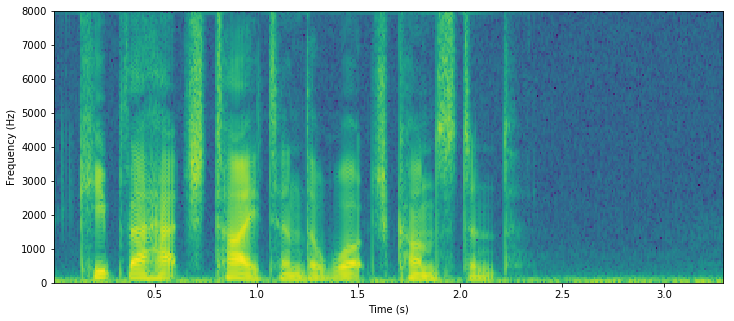

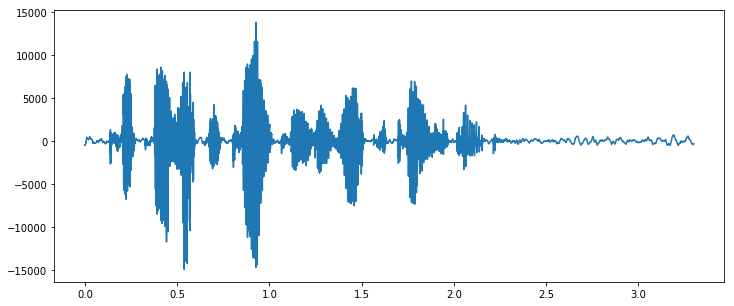

In [5]:
def read_label_file(filename):
    with open(filename, 'r') as myfile:
        data = myfile.readlines()
    label_list = []
    
    for i,line in enumerate(data):
        label = {}
        label['start'] = (float(line.split()[0])/10000000)
        label['end'] = (float(line.split()[1])/10000000)
        
        p0, lp = line.split()[2].split(":")[0].split("~")
        p1, lp = lp.split("-")
        p2, lp = lp.split("+")
        p3, p4 = lp.split("=")
        label['phone'] = "-".join([p0,p1,p2,p3,p4])
        label_list.append(label)
    return label_list

def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, pylab.int16)
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

def gen_spectogram(wav_filename):
    sound_info, frame_rate = get_wav_info(wav_filename)
    pylab.figure(figsize=(12, 5))
    #pylab.subplot(111)
    #pylab.title('spectrogram of %r' % wav_file)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.show()

    plt.clf()
    plt.figure(figsize=(12,5))
    x = [x/16000.0 for x in range(0,len(sound_info))]
    plt.plot(x,sound_info)
    plt.show()

gen_spectogram('./original/wav/utt1.wav')

## Fixed Length Alignment

In [6]:
def get_vector_mean(params, index):
    if index==0:
        return params[0]
    elif index>=len(params):
        return params[-1]
    else:
        return params[index]/2 + params[index-1]/2
    
def align_trajectory(org_params, gen_params, mean_replacement=True):
    valid_perms = [(0,[])]#initial condition, score = 0, substuted 0 locations = []
    len_diff = abs(len(org_params) - len(gen_params))

    if len(org_params)>len(gen_params):
        long_params = org_params
        short_params = gen_params
        pad=True
    else:
        long_params = gen_params
        short_params = org_params
        pad=False
        
    long_params=norm_array(long_params)
    short_params=norm_array(short_params)

    for i,x in enumerate(short_params):
        #print i
        new_valid_perms = [] # append padded or substituted result

        for perm in valid_perms:
            pads_made = len(perm[1])
            remaining_pads = len_diff - pads_made
            score = perm[0]

            #substitute
            if i+remaining_pads<=len(org_params)-1:#ensure we don't cross smaller trajectory's index
                #l2 = score + np.linalg.norm(long_params[i] - short_params[i-pads_made], 2)#l2-norm between two vectors
                l2 = score + (long_params[i]-short_params[i-pads_made])**2
                new_valid_perms.append((l2, perm[1]))
            #pad
            if remaining_pads>0:#spaces remaining
                #print i, pads_made
                if not mean_replacement:
                    #l2 = score + np.linalg.norm(long_params[i], 2)#l2-norm of vector against 0-vector
                    l2 = score + long_params[i]**2
                else:
                    #l2 = score + np.linalg.norm(long_params[i] - get_vector_mean(short_params,i-pads_made), 2)#l2-norm against mean vector # 
                    l2 = score + (long_params[i]-get_vector_mean(short_params,i-pads_made))**2
                subs = perm[1] + [i-pads_made]
                new_valid_perms.append((l2,subs))
                #if (i-pads_made==414):
                #print i, pads_made, np.linalg.norm(long_params[i] - get_vector_mean(short_params,i-pads_made), 2)
        valid_perms = []
        n_pad_max_dist={}

        for n, new_perm in enumerate(new_valid_perms):#keep only highest scoring permutation for a given number of paddings made
            n_pad = len(new_perm[1])
            score = new_perm[0]
            if n_pad in n_pad_max_dist:
                if score<n_pad_max_dist[n_pad][1]:
                    n_pad_max_dist[n_pad] = (n,score)
            else:
                n_pad_max_dist[n_pad] = (n,score)
       # print "===================================={}====================================".format(i)
       # print new_valid_perms
       # print n_pad_max_dist
        for n_pad in n_pad_max_dist:
            filter_perm_idx = n_pad_max_dist[n_pad][0]
            valid_perms.append(new_valid_perms[filter_perm_idx])
    #print valid_perms
       # print "\n"
    x_arr = valid_perms[-1][1]
    #print x_arr
    if(pad):
        substitutions = np.array(x_arr) + np.array(range(0,len_diff))
        for idx in list(substitutions):
            if mean_replacement:
                gen_params = np.insert(gen_params, idx, get_vector_mean(gen_params, idx), 0)
            else:
                gen_params = np.insert(gen_params, idx, np.zeros(np.size(gen_params[0])), 0)
    else:
        deletions = np.array(x_arr) - np.array(range(0,len_diff))
        for idx in list(deletions):
            gen_params = np.delete(gen_params, idx, 0)
    
    return gen_params

### DTW Alignment

DTW Aligned - Unnormalized - L2-Norm: 79037.8917034 Normalised L2-Norm, 1042.0000877
DTW Aligned - Normalized - L2-Norm: 63212.4747504 Normalised L2-Norm, 733.000065915
Fixed Aligned - L2-Norm: 45447.5883379 Normalised L2-Norm, 548.000011024
Fixed Aligned with Initial Zeros Stripped - L2-Norm: 45447.5883379 Normalised L2-Norm, 548.000005881


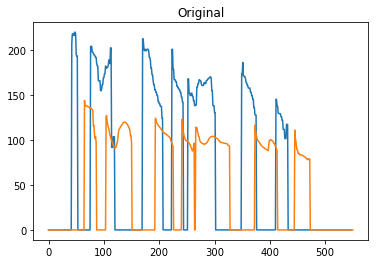

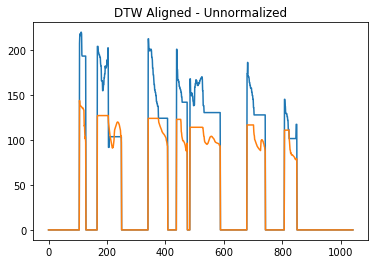

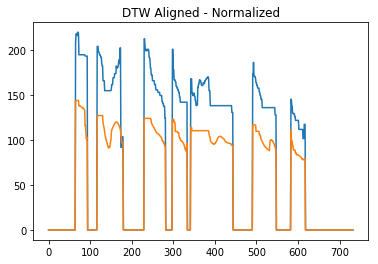

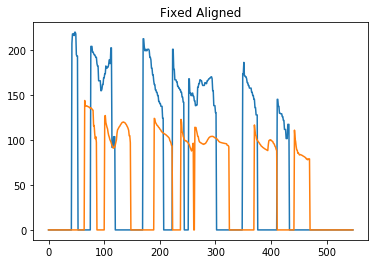

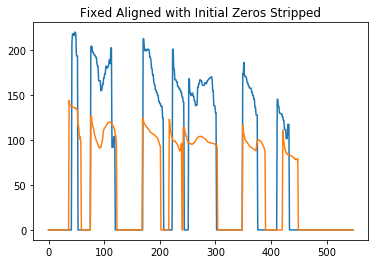

In [7]:
def norm_array(arr):
    mean = np.mean(arr)
    std = np.sqrt(np.var(arr))
    return (arr-mean)/std

def dtw_alignment(s1, s2, std=True):
    if(std):
        path, score = dtw_path(norm_array(s1), norm_array(s2))
    else:
        path, score = dtw_path(s1, s2)

    new_original = []
    new_label_gen = []
    for tup in path:
        new_original.append(s1[tup[0]])
        new_label_gen.append(s2[tup[1]])
    
    return np.array(new_original), np.array(new_label_gen)

x=3
label_gen = load_traj('./traj/utt1.f0', 1)
original = cmpdata['utt1']['f0'][0]


    
plt.clf()
plt.plot(original)
plt.plot(label_gen)
plt.title("Original")

new_o, new_l = dtw_alignment(original, label_gen,False)
label = "DTW Aligned - Unnormalized"
print "{} - L2-Norm: {} Normalised L2-Norm, {}".format(label, (norm(new_o - new_l, ord=2)), (norm(norm_array(new_o) - norm_array(new_l), ord=2)))
plt.figure()
plt.title(label)
plt.plot(new_o)
plt.plot(new_l)

new_o, new_l = dtw_alignment(original, label_gen,True)
label = "DTW Aligned - Normalized"
print "{} - L2-Norm: {} Normalised L2-Norm, {}".format(label, (norm(new_o - new_l, ord=2)), (norm(norm_array(new_o) - norm_array(new_l), ord=2)))
plt.figure()
plt.title(label)
plt.plot(new_o)
plt.plot(new_l)

new_l = align_trajectory(original, label_gen, mean_replacement=True)
label = "Fixed Aligned"
print "{} - L2-Norm: {} Normalised L2-Norm, {}".format(label, (norm(original - new_l, ord=2)), (norm(norm_array(original) - norm_array(new_l), ord=2)))
plt.figure()
plt.title(label)
plt.plot(original)
plt.plot(new_l)

new_l = align_trajectory(original, label_gen[40:], mean_replacement=True)
label = "Fixed Aligned with Initial Zeros Stripped"
print "{} - L2-Norm: {} Normalised L2-Norm, {}".format(label, (norm(original - new_l, ord=2)), (norm(norm_array(original) - norm_array(new_l), ord=2)))
plt.figure()
plt.title(label)
plt.plot(original)
plt.plot(new_l)

### Alignment Plots

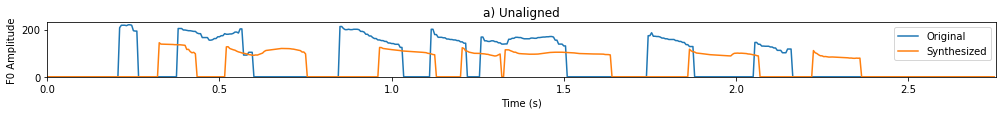

26.2111281313


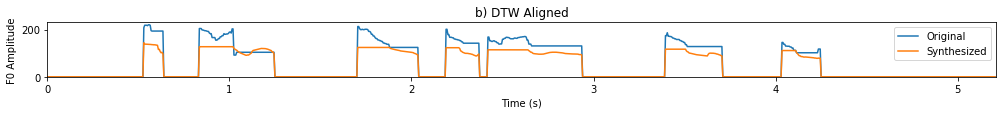

36.5962357473


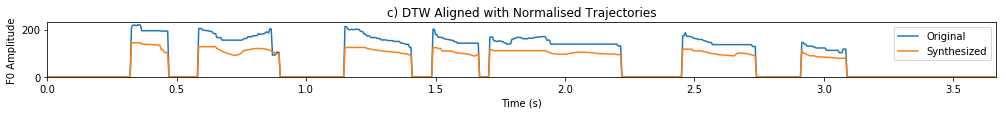

94.4990243237


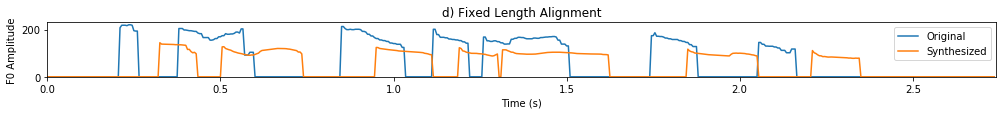

56.4690867539


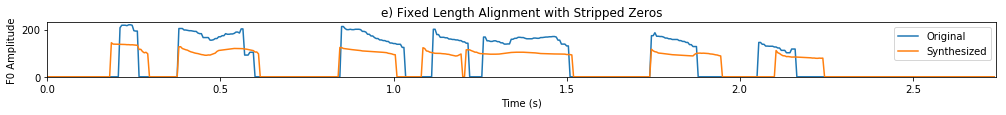

47.7763598736


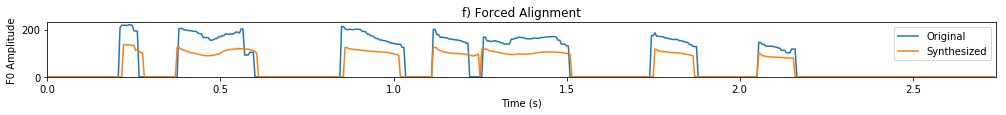

In [8]:
def f0_plot(org_f0, gen_f0, savefile="", title=""):
    plt.clf()
    plt.figure(figsize=(17,1.))
    plt.plot([0.005*x for x in range(0,len(org_f0))], org_f0, label='Original')
    plt.plot([0.005*x for x in range(0,len(gen_f0))], gen_f0, label='Synthesized')
    
    plt.xlim([0, 0.005*max(len(org_f0),len(gen_f0))])
    
    if(len(gen_f0)==len(org_f0)):
        diff = ((gen_f0).reshape(org_f0.shape))-(org_f0)
        sq_diff = diff*diff
        norm = (sum(sq_diff))/len(gen_f0)
        print np.sqrt(norm)
    
    y=(max(max(org_f0),max(gen_f0)))
    y=(y-y%10)+10
    plt.ylim([0, y])
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('F0 Amplitude')
    plt.legend(loc=1)
    #if savefile=="":
    plt.show()
    #else:
    #    plt.savefig('figures/6_{}_align.eps'.format(savefile), format='eps', dpi=1000, bbox_inches='tight')  
        
def RMSE(gen_f0, org_f0):
    diff = ((gen_f0).reshape(org_f0.shape))-(org_f0)
    sq_diff = diff*diff
    norm = (sum(sq_diff))/len(gen_f0)
    return np.sqrt(norm)

f0_plot(original, label_gen, 'none', 'a) Unaligned')        

new_o, new_l = dtw_alignment(original, label_gen,False)
f0_plot(new_o, new_l, 'DTW', 'b) DTW Aligned')

new_o, new_l = dtw_alignment(original, label_gen,True)
f0_plot(new_o, new_l, 'DTW_norm', 'c) DTW Aligned with Normalised Trajectories')

fixed = align_trajectory(original, label_gen, mean_replacement=True)
f0_plot(original, fixed, 'fixed', 'd) Fixed Length Alignment')

strip = align_trajectory(original, label_gen[40:-20,:], mean_replacement=True)
f0_plot(original, strip, 'strip', 'e) Fixed Length Alignment with Stripped Zeros')

f0_plot(original, load_traj('./mass_exp/utt1/traj-dur/utt1.f0',1), 'force', 'f) Forced Alignment')

### Experts

### Trajectory Modelling

See Matt Shannon's  slides for info

http://mi.eng.cam.ac.uk/~sms46/papers/shannon2014insights-slides.pdf

http://mi.eng.cam.ac.uk/~sms46/papers/shannon2012analysis-poster.pdf

http://mi.eng.cam.ac.uk/~sms46/papers/shannon2011modelling-slides.pdf

---

In [9]:
# Read in experts
def init_dict(elemList):
    rdict = {}
    for elem in elemList:
        rdict[elem] = []
    return rdict

def np_dict(in_dict):
    for elem in in_dict:
        in_dict[elem] = np.array(in_dict[elem])
    return in_dict

def read_mcep(filename):
    mcep_dict = init_dict(['static-mean','delta-mean','delta-delta-mean','static-var','delta-var','delta-delta-var'])
    
    with open(filename, 'r') as myfile:
        data = myfile.readlines()
        
    for i,line in enumerate(data):
        if (len(line.split())>1):
            static_mean, delta_mean, delta_delta_mean, static_var, delta_var, delta_delta_var = [float(x) for x in line.split()]
            mcep_dict['static-mean'].append(static_mean)
            mcep_dict['delta-mean'].append(delta_mean)
            mcep_dict['delta-delta-mean'].append(delta_delta_mean)
            mcep_dict['static-var'].append(static_var)
            mcep_dict['delta-var'].append(delta_var)
            mcep_dict['delta-delta-var'].append(delta_delta_var)

    return np_dict(mcep_dict)

def read_durations(filename, get_labels=False):
    state_means = []
    label_list = []

    
    with open(filename, 'r') as myfile:
        data = myfile.readlines()
        
    for i,line in enumerate(data):
        if (len(line.split())>1):
            line_flt = [float(x) for x in line.split()]
            state_means += line_flt[0:5]
        elif get_labels:
            label_list.append(line.split("-")[1].split("+")[0])
    if get_labels:
        return label_list
    return np.ndarray.astype(np.rint(np.array(state_means)),'int')
    
def dur_weighted_experts(mcep_expert, dur_expert_int):#repeats and stacks state means/variances by their durations, vectorizes mean, delta and delta-delta before returning
    #dur_expert_int = np.ndarray.astype(np.rint(dur_expert['state-means']),'int')
    expanded_mcep_expert = {}
    for elem in mcep_expert:
        expanded_expert = np.array([])
        for i in range (0, dur_expert_int.shape[0]):
            mean_repeated = np.repeat(mcep_expert[elem][i], dur_expert_int[i])
            expanded_expert=np.append(expanded_expert, mean_repeated)
        expanded_mcep_expert[elem] = expanded_expert
        
    mean = np.column_stack((expanded_mcep_expert['static-mean'], expanded_mcep_expert['delta-mean'], expanded_mcep_expert['delta-delta-mean'])).reshape(-1,1)
    var = np.column_stack((expanded_mcep_expert['static-var'], expanded_mcep_expert['delta-var'], expanded_mcep_expert['delta-delta-var'])).reshape(-1,1)[:,0]
    return mean, var

def get_weight_matrix(column_dim):
    weight_matrix = np.array([[0,0,1,0,0],
         [-0.2, -0.1, 0, 0.1, 0.2],
         [0.285714, -0.142857, -0.285714, -0.142857, 0.285714]])
    pad = (weight_matrix.shape[1]-1)
    
    W_matrix = np.zeros([column_dim,  column_dim/3 + pad])
    for column in range(0,W_matrix.shape[1] - pad):
        row = column * 3
        W_matrix[row:row+3, column:column+5] = weight_matrix
        
    return W_matrix[:,pad/2:-pad/2]

---
**See handout 2, slide 16-20 for general trajectory generation**

**See handout 2, slide 5 for duration repetition**

**See II.A for static/delta stacking: https://ieeexplore.ieee.org/document/6012516/**

**See 2 for stacking https://pdfs.semanticscholar.org/1250/79aea59a8db71f7fb27a2a96416931ac04a2.pdf**

$\bar{\mu}_q$ = mcep_mean = MCEP duration-repeated mean

if $int(\mu_{dur-static}) = [2, 1 \dots]$

and $\mu_{mcep-static} = [x_0, x_1 \dots]$ 

and $\mu_{\nabla mcep} = [\nabla x_0, \nabla x_1 \dots]$ 

and $\mu_{\nabla^2 mcep} = [\nabla^2 x_0, \nabla^2 x_1 \dots]$ 

=> mix static, delta, delta-delta parameters into one vector = [$x_0, \nabla x_0, \nabla^2 x_0, x_1, \nabla x_1, \nabla^2 x_1, x_2, \nabla x_2, \nabla^2 x_2  \dots$]

=> repeat parameters by their durations: $x_0$ twice, $x_1$ once ...

$\bar{\mu}_q = [x_0, \nabla x_0, \nabla^2 x_0, x_0, \nabla x_0, \nabla^2 x_0, x_1, \nabla x_1, \nabla^2 x_1 \dots]'$

---

$\bar{\Sigma}_q$ = mcep_var = MCEP duration-repeated diagonalised variance

Apply same processing as $\bar{\mu}_q$, then diagnolise the array (handout 2, slide 18)

---

**See II.A for W matrix design: https://ieeexplore.ieee.org/document/6012516/**

W = window matrix

$w$ = 

\begin{bmatrix}
    0.00 & 0.00 & 1.00 & 0.00 & 0.00 \\
    -0.20 & -0.10 & 0.00 & 0.10 & 0.20 \\
    0.29 & -0.14 & -0.29 & -0.14 & 0.29\\
\end{bmatrix}

$w$ = 

\begin{bmatrix}
    w_{11} & w_{12} & w_{13} & w_{14} & w_{15} \\
    w_{21} & w_{22} & w_{23} & w_{24} & w_{25} \\
    w_{31} & w_{32} & w_{33} & w_{34} & w_{35} \\
\end{bmatrix}

=> Stack w diagonally. Move row(w) rows and 1 columns for each stacking.

=> Overstack and then remove first 2 and last 2 columns. Final number of rows should match length of $\bar{\mu}_q$

$W$ (before trimming first and final 2 columns) = 

\begin{bmatrix}
    w_{11} & w_{12} & w_{13} & w_{14} & w_{15} & 0 & 0 & 0 & 0 & 0 & \dots \\
    w_{21} & w_{22} & w_{23} & w_{24} & w_{25} & 0 & 0 & 0 & 0 & 0 & \dots \\
    w_{31} & w_{32} & w_{33} & w_{34} & w_{35} & 0 & 0 & 0 & 0 & 0 & \dots \\
    0 & w_{11} & w_{12} & w_{13} & w_{14} & w_{15} & 0 & 0 & 0 & 0 & \dots \\
    0 & w_{21} & w_{22} & w_{23} & w_{24} & w_{25} & 0 & 0 & 0 & 0 & \dots \\
    0 & w_{31} & w_{32} & w_{33} & w_{34} & w_{35} & 0 & 0 & 0 & 0 & \dots \\
    0 & 0 & w_{11} & w_{12} & w_{13} & w_{14} & w_{15} & 0 & 0 & 0 & \dots \\
    0 & 0 & w_{21} & w_{22} & w_{23} & w_{24} & w_{25} & 0 & 0 & 0 & \dots \\
    0 & 0 & w_{31} & w_{32} & w_{33} & w_{34} & w_{35} & 0 & 0 & 0 & \dots \\
    0 & 0 & 0 & w_{11} & w_{12} & w_{13} & w_{14} & w_{15} & 0 & 0 & \dots \\
    0 & 0 & 0 & w_{21} & w_{22} & w_{23} & w_{24} & w_{25} & 0 & 0 & \dots \\
    0 & 0 & 0 & w_{31} & w_{32} & w_{33} & w_{34} & w_{35} & 0 & 0 & \dots \\
    0 & 0 & 0 & 0 & w_{11} & w_{12} & w_{13} & w_{14} & w_{15} & 0 & \dots \\
    0 & 0 & 0 & 0 & w_{21} & w_{22} & w_{23} & w_{24} & w_{25} & 0 & \dots \\
    0 & 0 & 0 & 0 & w_{31} & w_{32} & w_{33} & w_{34} & w_{35} & 0 & \dots \\
    0 & 0 & 0 & 0 & 0 & w_{11} & w_{12} & w_{13} & w_{14} & w_{15} & \dots \\
    0 & 0 & 0 & 0 & 0 & w_{21} & w_{22} & w_{23} & w_{24} & w_{25} & \dots \\
    0 & 0 & 0 & 0 & 0 & w_{31} & w_{32} & w_{33} & w_{34} & w_{35} & \dots \\
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots \\
\end{bmatrix}

---

Calculations:

**See handout 4, slide 5**

1. $\Sigma_q = (W' \bar{\Sigma}_q^{-1}W)^{-1}$ 

2. $\mu_q = \Sigma_q W' \bar{\Sigma}_q^{-1}\bar{\mu}_q^{-1}$

In [12]:
filename="utt1"
dim=4
#Read Duration Experts - return only state duration means
int_dur_exp = read_durations('./{root_f}/{filename}/expts/{dim}/{filename}.dur.expt'.format(root_f=root_folder, filename=filename, dim=dim))

#Read MCEP experts - return static, delta and delta-delta params for mean and varince
mcep_exp = read_mcep('./{root_f}/{filename}/expts/{dim}/{filename}.cmp.expt'.format(root_f=root_folder, filename=filename, dim=dim))

#Duplication expert states by their durations
mcep_mean, mcep_var = dur_weighted_experts(mcep_exp, int_dur_exp)

#Window matrix
W = get_weight_matrix(mcep_mean.shape[0])

#sigma_bar_q inverse
mcep_cov = np.diag(mcep_var)
mcep_cov_inv = np.linalg.inv(mcep_cov)

def poe_trajectory(mcep_mean, mcep_var, mcep_cov_inv, W):
    W_mcep_cov_inv = W.T.dot(mcep_cov_inv)

    #1.
    q_cov = np.linalg.inv(W_mcep_cov_inv.dot(W))#can replace w/ cholesky for optimal performance

    #2.
    q_mean = q_cov.dot(W_mcep_cov_inv).dot(mcep_mean)
    
    return q_mean, q_cov
    
q_mean, q_cov = poe_trajectory(mcep_mean, mcep_var, mcep_cov_inv, W)

### Global Variance

### GV Expert

---

** See section 3 for calculations https://pdfs.semanticscholar.org/1250/79aea59a8db71f7fb27a2a96416931ac04a2.pdf **

** See section 3.2 for calculations, simplified: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1415037 **

** may/may not be relevant: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4960511 **

** See section 2.1 for high-level discussion http://mi.eng.cam.ac.uk/~sms46/papers/shannon2013fast.pdf**

---

=> Read $\mu_{gv}, \Sigma_{gv}$ from global variance experts pdf

C = $\mu_q$

M = $\bar{\mu}_q$

U_inv = $\bar{\Sigma}_q^{-1}$

T = Total Durations

$\omega$ = $1/(3T)$ -- from paper

$p_v$ = $1/\mu_{gv}$

---
** Equations from paper to implement **

Gradient descent step update (20)

$C^{(i+1)} = C^{(i)} + \alpha . \nabla C^{(i)}$

Gradient calculation (21)

$\frac{\partial L}{\partial C} = \omega (-W^{T}U^{-1}WC + W^{T}U^{-1}M) + [v'^{T}_{t}(1) + v'^{T}_{t}(2) + v'^{T}_{t}(3) \dots]^{T}$

$v'_t = [v'_t (1), v'_t (2), v'_t (3) \dots v'_t (D)]$

$v'_t (d) = -\frac{2}{T}p^{d}_{v} (v(C) - \mu_v) (c_t(d) - \bar{c})$

d=1, v'_t simplifies

=> $v'_t = \frac{-2 . (\sigma_{\mu_q} - \mu_{gv})}{T . \Sigma_{gv}} \times \mu_q - \mu_C$

=> $\frac{1}{3T} . (-W^{T} \bar{\Sigma}^{-1}_q W\mu_q + W^{T} \bar{\Sigma}^{-1}_q \bar{\mu}_q) + v'_t$

(C is the only vector with dimensions this equation)

In [13]:
def read_gv(filename, dim):
    
    with open(filename, 'rb') as myfile:
        data = myfile.readlines()
    data_len = int(len(data)/2)
    return float(data[dim]),float(data[data_len+dim])

gv_mean, gv_var = read_gv('gv-mcep.txt',dim)

T = float(q_mean.shape[0])
lr = 0.10
W = get_weight_matrix(mcep_mean.shape[0])
maxIter = 200


def q_gv_mean_delta(q_gv_mean, W, mcep_cov_inv, mcep_mean, gv_mean, gv_var, T):
    q_gv_mean_mean = np.mean(q_gv_mean)
    q_gv_mean_var = np.var(q_gv_mean)
    W_mcep_cov_inv = W.T.dot(mcep_cov_inv)
    q_gv_mean_grad = (1/(3*T)) * (-W_mcep_cov_inv.dot(W).dot(q_gv_mean) + W_mcep_cov_inv.dot(mcep_mean)) -2 / (T * gv_var) * (q_gv_mean_var - gv_mean) * (q_gv_mean - q_gv_mean_mean)
    return q_gv_mean_grad

def optimize_q_gv(maxIter, lr, criteria, q_gv_mean, W, mcep_cov_inv, mcep_mean, gv_mean, gv_var, T):
    stop_criteria = False
    for i in range(maxIter):
        if (i<maxIter and not stop_criteria):
            #if i%250==0 and i!=0:
                #print 'Iteration: {}'.format(i)   
                
            q_gv_mean_grad = q_gv_mean_delta(q_gv_mean, W, mcep_cov_inv, mcep_mean, gv_mean, gv_var, T)
            q_gv_mean = q_gv_mean + lr * q_gv_mean_grad

            stop_criteria = max(q_gv_mean_grad) < criteria and i>10
            if (stop_criteria or i ==maxIter-1):
                print 'Total Iterations: {}'.format(i)
    return q_gv_mean
gve_optimization = optimize_q_gv(maxIter, 0.001, 1e-10, q_mean, W, mcep_cov_inv, mcep_mean, gv_mean, gv_var, T)

Total Iterations: 199


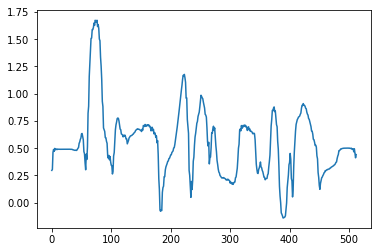

In [14]:
plt.plot(gve_optimization)

### GV Constraint

---

**Paper: http://mi.eng.cam.ac.uk/~sms46/papers/shannon2013fast.pdf**

---

Global variance

$v(c) \overset{\Delta}{=} \frac{1}{T} \sum_{t} c^2_t - (\sum_{t} c^t)^2 = \frac{1}{T}c^T J C$

Section 2.1 gives formula for G(c) (utility function) to optimise

$G(c) \overset{\Delta}{=} -\frac{1}{2}c^{T}Pc + b^T c + \omega \log \mathcal{N}(v(c); \mu_{GV}, \Sigma_{GV})$

$G(c) \overset{\Delta}{=} -\frac{1}{2}c^{T}Pc + b^T c - \omega . \frac{({ \sigma^2_c - \mu_{GV}})^{2}}{2 \sigma^2_{GV}}  - \frac{1}{2} \log (2\pi \sigma^{2}_{GV})$

Remove constant term for minimisation, 

$G(c) \overset{\Delta}{=} -\frac{1}{2}c^{T}Pc + b^T c - \omega . \frac{({ \sigma^2_c - \mu_{GV}})^{2}}{2 \sigma^2_{GV}}$

"It has been noted that in practice the effect of this utility function
is typically to set the global variance of the generated trajectory to
be almost exactly equal to $µ_{GV}$ [11, 20]."

---

Section 3.1 gives formula for trajectory generation

$\hat{c}(\lambda) \overset{\Delta}{=} (P-\lambda J)^{-1} b $

$\hat{c}(\lambda) \overset{\Delta}{=} (\Sigma^{-1}_q-\lambda I - \frac{1}{T} * M)^{-1} . \Sigma^{-1}_q.\mu_q $

---

Section 2 gives P, b, J

$P = \Sigma^{-1}_q$

$b = P.\mu_q$

$J \overset{\Delta}{=} I - \frac{1}{T} * M$ where $M = $ np.ones([T, T])

$v(c) = \sigma^2_{\hat{c}}$

---

$\omega = 3T$

http://mi.eng.cam.ac.uk/~sms46/papers/shannon2013fast-errata.txt

In section 2.1 the typical value for $\omega$ should be $3 T$ instead of
  $1 / (3 T)$.

In [15]:
def calc_c_hat(P, J, b, lmb):
    return np.dot(np.linalg.inv(P - lmb * J), b)
    
def utility_function(lmb, P, b, J, w, gv_mean, gv_var):
    c = calc_c_hat(P, J, b, lmb)
    var_c = np.var(c)
    return -np.float(-0.5 * c.T.dot(P).dot(c) + b.T.dot(c) - w * ((var_c - gv_mean)**2)/(2 * gv_var))

In [17]:
T = int(q_mean.shape[0]) 
w = (3*T)
q_cov_inv = np.linalg.inv(q_cov) # P
b = q_cov_inv.dot(q_mean)

J = np.eye(T) - 1.0/T * np.ones([T,T])

optimization = minimize(fun=utility_function, x0=1.0, args=(q_cov_inv, b, J, w, gv_mean, gv_var), tol=1e-5) 

c = calc_c_hat(q_cov_inv, J, b, optimization.x)

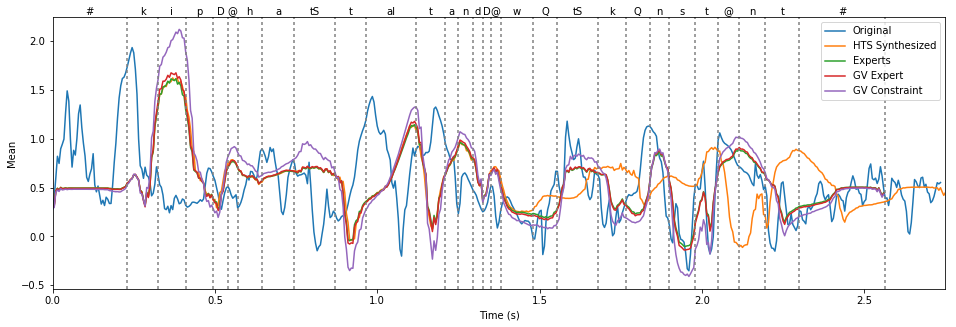

In [19]:
labels_list = read_durations('./{root_f}/{filename}/expts/{dim}/{filename}.dur.expt'.format(root_f=root_folder, filename=filename, dim=dim), True)
lab_ends = np.cumsum(np.sum(int_dur_exp.reshape(-1,5),axis=1))*0.005
lab_ends_full = np.cumsum(int_dur_exp)*0.005
lab_starts = np.concatenate(([0],lab_ends[0:-1]))
lab_ticks = (lab_ends + lab_starts)/2

org_mcep = cmpdata[filename]['mcep'][dim-1]
synth_mcep = load_traj('./{root_f}/{filename}/traj/{filename}.mcep'.format(root_f=root_folder, filename=filename, dim=dim),60)[:,dim-1]

plot_x = [0.005*x for x in range(0,len(q_mean))]
plot_x_synth = [0.005*x for x in range(0,len(synth_mcep))]
plot_x_org = [0.005*x for x in range(0,len(org_mcep))]

plt.clf()
    
#plt.plot(org_mcep, label="Original")
#plt.plot(c, label="GV Constraint")
#plt.plot(gve_optimization, label="GV Expert")
#plt.plot(plot_x_org, org_mcep, label="Original")
#plt.plot(plot_x_synth, synth_mcep, label="HTS Synthesized")

#1.1 Repeated vs Trajectory Plot
'''
plt.plot(plot_x,mcep_mean[::3], label="Experts Repeated")
plt.plot(plot_x,q_mean, label="Experts Trajectory")
plt.xlim([0,max(plot_x)])
for i in range(0,len(labels_list)):
    plt.text(lab_ticks[i], plt.gca().get_ylim()[1], labels_list[i], rotation=0, horizontalalignment='center', verticalalignment='bottom')
for i in range(0,len(lab_ends_full)):
    plt.axvline(x=lab_ends_full[i], color='gray',  dashes=[2, 2])

#1.2 Comparison

plt.plot(plot_x_org, org_mcep, label="Original")
plt.plot(plot_x_synth, synth_mcep, label="HTS Synthesized")
plt.plot(plot_x,q_mean, label="Experts Trajectory")
plt.xlim([0,max(plot_x+plot_x_org+plot_x_synth)])

for i in range(0,len(labels_list)):
    plt.axvline(x=lab_ends[i], color='gray',  dashes=[2, 2])
    plt.text(lab_ticks[i], plt.gca().get_ylim()[1], labels_list[i], rotation=0, horizontalalignment='center', verticalalignment='bottom')
    

'''
#2.1 Trajectories
plt.figure(figsize=(16,5))
plt.plot(plot_x_org, org_mcep, label="Original")
plt.plot(plot_x_synth, synth_mcep, label="HTS Synthesized")
plt.plot(plot_x,q_mean, label="Experts")
plt.plot(plot_x, gve_optimization, label="GV Expert")
plt.plot(plot_x, c, label="GV Constraint")
plt.xlim([0,max(plot_x+plot_x_org+plot_x_synth)])


for i in range(0,len(labels_list)):
    plt.axvline(x=lab_ends[i], color='gray',  dashes=[2, 2])
    plt.text(lab_ticks[i], plt.gca().get_ylim()[1], labels_list[i], rotation=0, horizontalalignment='center', verticalalignment='bottom')

#2.2 Trajectories
plt.xlabel("Time (s)")
plt.ylabel("Mean")
plt.legend(loc=1)
#plt.savefig('figures/23_all.eps', format='eps', dpi=1000, bbox_inches='tight')
#plt.grid()
plt.show()

In [20]:
print ("RMSE Stats")
new_o, new_l = dtw_alignment(synth_mcep, org_mcep,False)
print "Synth vs Original: {:1.3f}".format(float(RMSE(new_o, new_l)))
new_o, new_l = dtw_alignment(org_mcep, mcep_mean[::3],False)
print "Original vs Repeated: {:1.3f}".format(float(RMSE(new_o, new_l)))
new_o, new_l = dtw_alignment(synth_mcep, mcep_mean[::3],False)
print "Synth vs Repeated: {:1.3f}".format(float(RMSE(new_o, new_l)))
new_o, new_l = dtw_alignment(org_mcep, q_mean,False)
print "Original vs Expert: {:1.3f}".format(float(RMSE(new_o, new_l)))
new_o, new_l = dtw_alignment(synth_mcep, q_mean,False)
print "Synth vs Expert: {:1.3f}".format(float(RMSE(new_o, new_l)))

RMSE Stats
Synth vs Original: 0.117
Original vs Repeated: 0.121
Synth vs Repeated: 0.078
Original vs Expert: 0.118
Synth vs Expert: 0.019


In [21]:
def gen_all_traj(filename, dim):
    all_traj = {}
    
    #Read original waveform
    org_mcep = cmpdata[filename]['mcep'][dim-1]

    #Read Duration Experts - return only state duration means
    int_dur_exp = read_durations('./{root_f}/{filename}/expts/{dim}/{filename}.dur.expt'.format(root_f=root_folder, filename=filename, dim=dim))
    
    #Read MCEP experts - return static, delta and delta-delta params for mean and varince
    mcep_exp = read_mcep('./{root_f}/{filename}/expts/{dim}/{filename}.cmp.expt'.format(root_f=root_folder, filename=filename, dim=dim))

    #Duplication expert states by their durations
    mcep_mean, mcep_var = dur_weighted_experts(mcep_exp, int_dur_exp)
    #Window matrix
    W = get_weight_matrix(mcep_mean.shape[0])
    #sigma_bar_q inverse
    mcep_cov = np.diag(mcep_var)
    mcep_cov_inv = np.linalg.inv(mcep_cov)
    
    #get trajectory for PoE
    q_mean, q_cov = poe_trajectory(mcep_mean, mcep_var, mcep_cov_inv, W)

    #read GV expert
    gv_mean, gv_var = read_gv('gv-mcep.txt',dim-1)
    #Frames
    T = float(q_mean.shape[0])
    #gen trajectory for GV experts
    q_gve_mean = optimize_q_gv(3000, 0.01, 1e-2, q_mean, W, mcep_cov_inv, mcep_mean, gv_mean, gv_var, T)

    #variables for GV constraint
    w = (3*T)
    q_cov_inv = np.linalg.inv(q_cov) # P
    b = q_cov_inv.dot(q_mean)
    T = int(T)
    J = np.eye(T) - 1.0/T * np.ones([T,T])

    #optimize for lambda
    optimization = minimize(fun=utility_function, x0=1.0, args=(q_cov_inv, b, J, w, gv_mean, gv_var), tol=1e-5) 

    #get trajectory
    c = calc_c_hat(q_cov_inv, J, b, optimization.x)
    
    all_traj['original']=org_mcep
    all_traj['baseline']=mcep_mean[::3][:,0]
    all_traj['poe']=q_mean[:,0]
    all_traj['gv_expert']=q_gve_mean[:,0]
    all_traj['gv_constraint']=c[:,0]
    
    return all_traj

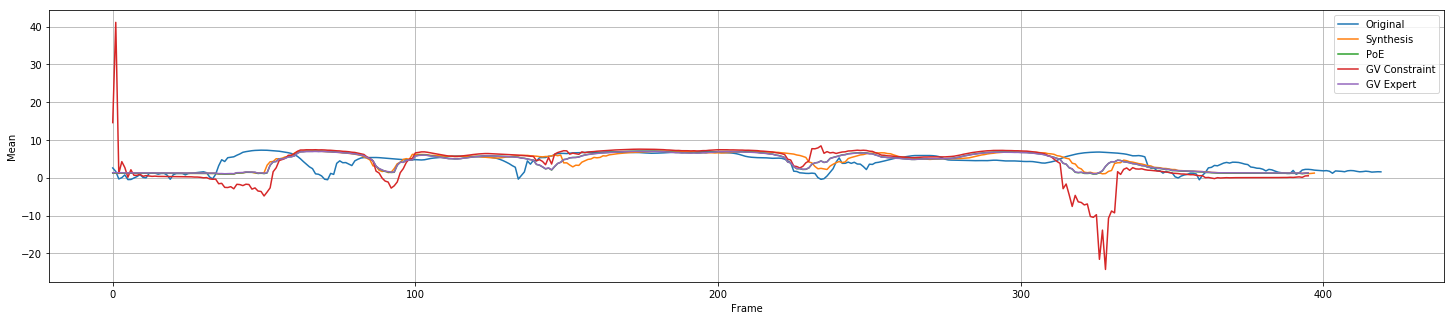

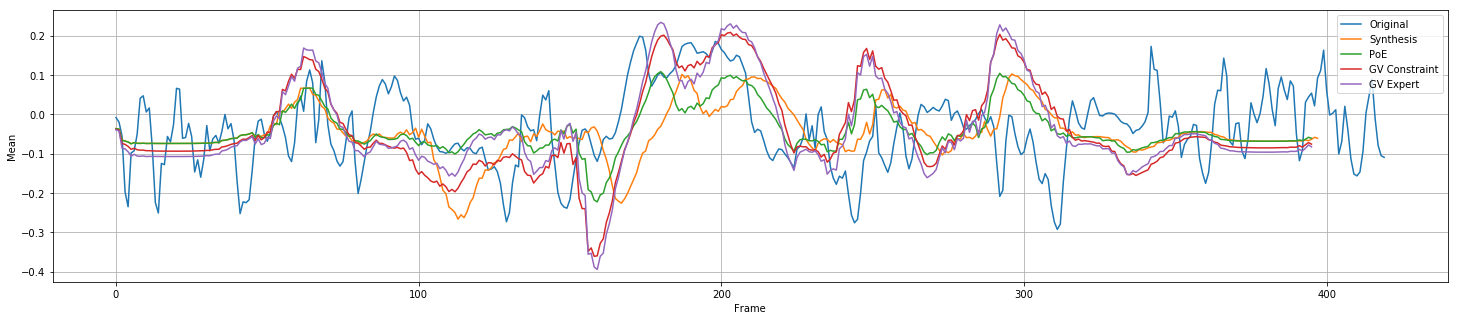

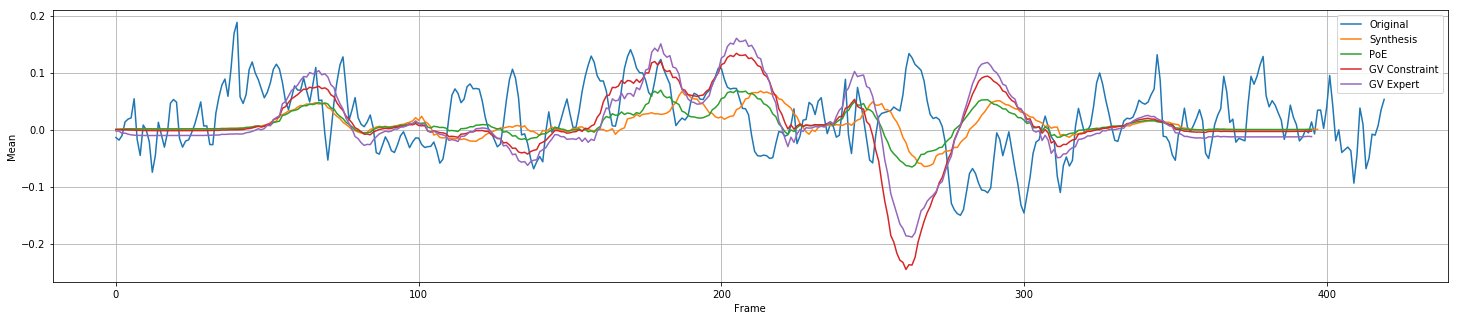

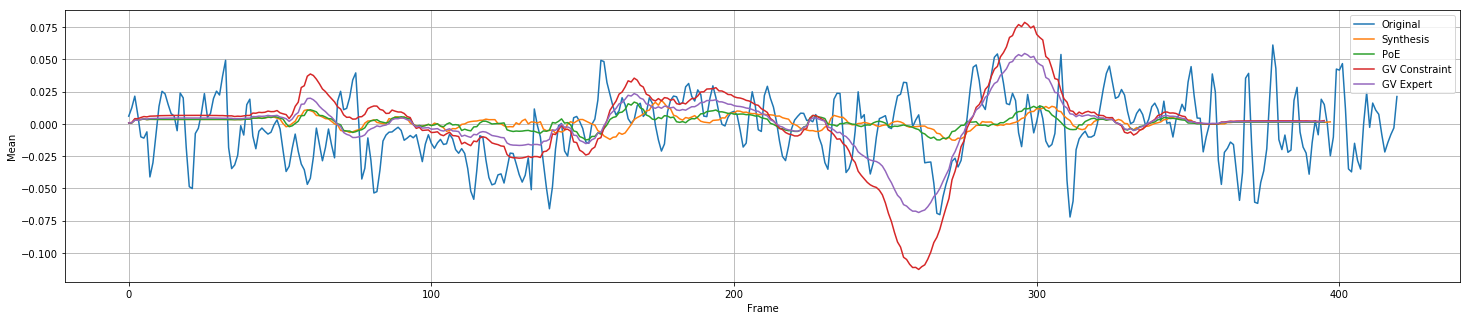

In [52]:
def plot_all_traj(traj):
    plt.clf()
    plt.figure(figsize=(25,5))
    plt.plot(traj['original'], label="Original")
    plt.plot(traj['synth'], label="Synthesis")
    plt.plot(traj['poe'], label="PoE")
    plt.plot(traj['gv_constraint'], label="GV Constraint")
    plt.plot(traj['gv_expert'], label="GV Expert")
    plt.xlabel("Frame")
    plt.ylabel("Mean")
    plt.legend(loc=1)
    plt.grid()
    plt.show()
for i in [1, 16, 31, 55]:
    plot_all_traj(res3['utt3'][i])

### Generating Trajectories for all utterances

In [27]:
res={}
for f in files:
    utt={}
    print f
    b=time.time()
    for mcep in mceps:
        print mcep
        a = time.time()
        utt[mcep]=gen_all_traj(f,mcep)
        print "Time: {}s".format(time.time() - a)
    print "Total Time: {}s".format(time.time() - b)
    res[f]=utt

utt1
1
Total Iterations: 815
Time: 10.5224699974s
2
Total Iterations: 11
Time: 0.493160009384s
3
Total Iterations: 422
Time: 5.64380311966s
4
Total Iterations: 818
Time: 10.0147550106s
5
Total Iterations: 244
Time: 3.90276503563s
6
Total Iterations: 237
Time: 3.75921106339s
7
Total Iterations: 203
Time: 2.89974594116s
8
Total Iterations: 186
Time: 2.83462905884s
9
Total Iterations: 165
Time: 2.96263623238s
10
Total Iterations: 102
Time: 1.80627298355s
11
Total Iterations: 133
Time: 2.2600569725s
12
Total Iterations: 99
Time: 2.04893183708s
13
Total Iterations: 66
Time: 1.41192913055s
14
Total Iterations: 79
Time: 1.52477788925s
15
Total Iterations: 62
Time: 1.2768368721s
16
Total Iterations: 195
Time: 3.32236218452s
17
Total Iterations: 44
Time: 1.11819005013s
18
Total Iterations: 256
Time: 3.83343505859s
19
Total Iterations: 43
Time: 0.94251704216s
20
Total Iterations: 346
Time: 4.96815991402s
21
Total Iterations: 39
Time: 0.93443107605s
22
Total Iterations: 151
Time: 2.61995482445s
2

In [49]:
pickle.dump(res3, open( "./mcep_traj_3_bkp.p", "wb" ))

In [143]:
###Fixing res issues with indexing
res3={}
for f in files:
    utt={}
    for m in range(1,61):
        t={}
        for traj in ['baseline', 'gv_expert', 'poe','gv_constraint']:
            t[traj]=res[f][m][traj][:,0]
        t['original']=res[f][m]['original']
        utt[m] = t
    res3[f]=utt

### Align all trajectories

In [248]:
align_res = {}
for f in files:
    t={}
    for m in range(1,61):
        if (m%10==0):
            print "{} {}".format(f,m)
        t2={}
        for traj in ['baseline', 'gv_expert', 'poe','gv_constraint']:
            t3={}
            new_o, new_l = dtw_alignment(res3[f][m]['original'], res3[f][m][traj],True)
            t3['dtw_org']=new_o
            t3['dtw_gen']=new_l
            new_l = align_trajectory(res3[f][m]['original'], res3[f][m][traj], mean_replacement=True)
            t3['fixed']=new_l
            t3['original']=res3[f][m]['original']
            t3['unaligned']=res3[f][m][traj]
            t2[traj]=t3
        t[m]=t2
    align_res[f]=t

utt1 10
utt1 20
utt1 30
utt1 40
utt1 50
utt1 60
utt2 10
utt2 20
utt2 30
utt2 40
utt2 50
utt2 60
utt3 10
utt3 20
utt3 30
utt3 40
utt3 50
utt3 60
utt4 10
utt4 20
utt4 30
utt4 40
utt4 50
utt4 60
utt5 10
utt5 20
utt5 30
utt5 40
utt5 50
utt5 60
utt6 10
utt6 20
utt6 30
utt6 40
utt6 50
utt6 60
utt7 10
utt7 20
utt7 30
utt7 40
utt7 50
utt7 60
utt8 10
utt8 20
utt8 30
utt8 40
utt8 50
utt8 60
utt9 10
utt9 20
utt9 30
utt9 40
utt9 50
utt9 60


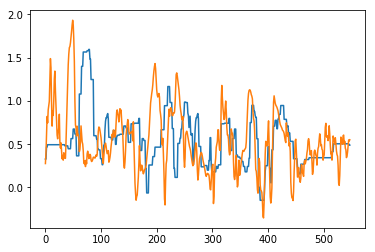

In [878]:
plt.plot(align_res['utt1'][4]['baseline']['fixed'])
plt.plot(align_res['utt1'][4]['baseline']['original'])

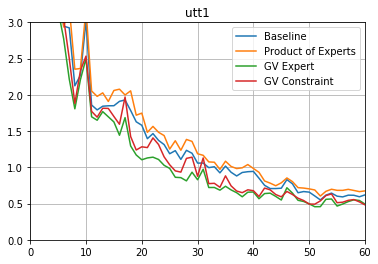

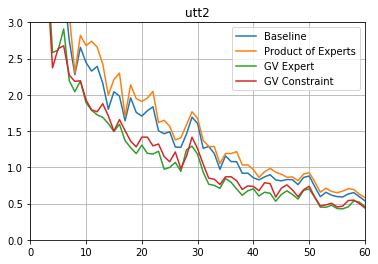

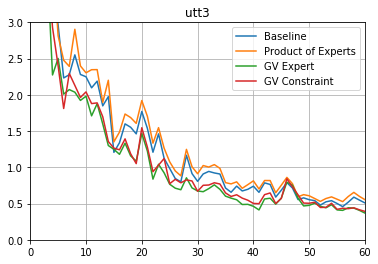

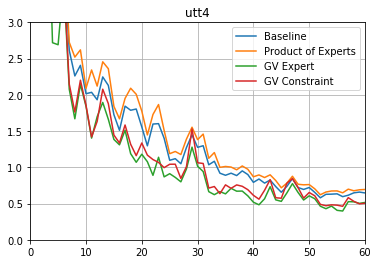

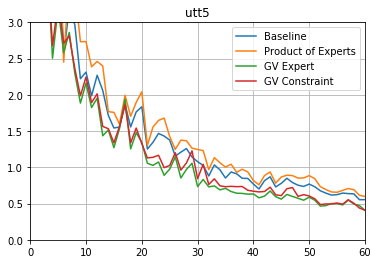

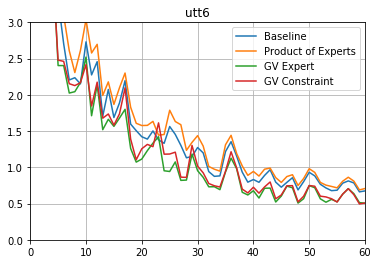

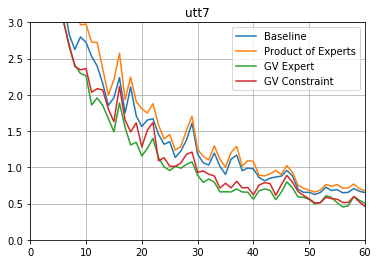

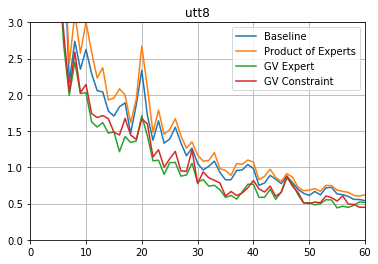

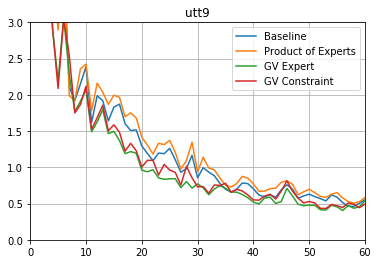

In [529]:
for f in files:
    stat='dtw'
    plt.figure()
    x=0
    #plt.plot(range(x+1,61),align_res_mcep_stats[f][stat]['baseline'][x:], label = "Baseline")
    plt.plot(range(x+1,61),align_res_mcep_stats[f][stat]['poe'][x:], label = "Product of Experts")
    plt.plot(range(x+1,61),align_res_mcep_stats[f][stat]['gv_expert'][x:], label = "GV Expert")
    plt.plot(range(x+1,61),align_res_mcep_stats[f][stat]['gv_constraint'][x:], label = "GV Constraint")
    plt.title(f)
    plt.legend()
    plt.axis([0, 60, 0, 3])
    #plt.axis([0, 60, 0, 0.01])
    plt.grid()

In [251]:
align_res_mcep_stats = {}
for f in files:
    res_dtw={}
    res_fixed={}
    res_var={}
    for traj in ['baseline', 'poe', 'gv_expert', 'gv_constraint']:
        dtw=[]
        fixed=[]
        var=[]
        for m in mceps:
            dtw.append(np.linalg.norm(align_res[f][m][traj]['dtw_gen'] - align_res[f][m][traj]['dtw_org'],ord=2))
            fixed.append(np.linalg.norm(align_res[f][m][traj]['fixed'] - align_res[f][m][traj]['original'],ord=2))
            var.append(np.var(align_res[f][m][traj]['unaligned']))
        res_dtw[traj] =dtw
        res_fixed[traj] = fixed
        res_var[traj] = var
    res_all={}
    res_all['dtw']=res_dtw
    res_all['fixed']=res_fixed
    res_all['var']=res_var
    align_res_mcep_stats[f]=res_all

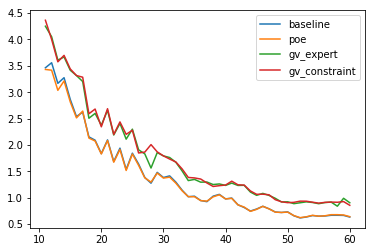

In [252]:
plt.figure()
f='utt1'
x=10
for traj in ['baseline', 'poe', 'gv_expert', 'gv_constraint']:
    plt.plot(mceps[x:], align_res_mcep_stats[f]['fixed'][traj][x:], label=traj)
plt.legend(loc=1)

In [253]:
pickle.dump(align_res, open( "./mcep_align_traj.p", "wb" ))
pickle.dump(align_res_mcep_stats, open( "./mcep_align_traj_stats.p", "wb" ))

### Generate Wav Files

Original vs Generated Wavs:
    - None
    - F0
    - MCEP
    - APF
    - F0 and MCEP
    - MCEP and APF
    - F0 and APF
    - F0, MCEP and APF

In [642]:

for f in files:
    print "processing {file_n}".format(file_n=f)
    subprocess.call("mkdir {root_f}/{file_n}/wav/feature_comparison_fa".format(root_f=root_folder, file_n=f).split(" "))
    for feature in ['none', 'f0','mcep','apf','f0_mcep', 'f0_apf', 'mcep_apf', 'f0_mcep_apf']:
        subprocess.call("mkdir {root_f}/{file_n}/wav/feature_comparison_fa/{feat}".format(root_f=root_folder, file_n=f, feat=feature).split(" "))
'''
    for traj in ['baseline_una', 'poe_una', 'gv_expert_una', 'gv_constraint_una']:
        subprocess.call("mkdir {root_f}/{file_n}/wav/mcep_generation/{feat}".format(root_f=root_folder, file_n=f, feat=traj).split(" "))

    #Make folders
    subprocess.call("mkdir {root_f}/{file_n}/wav/unaligned".format(root_f=root_folder, file_n=f).split(" "))
    subprocess.call("mkdir {root_f}/{file_n}/wav/unaligned/full".format(root_f=root_folder, file_n=f).split(" "))
    subprocess.call("mkdir {root_f}/{file_n}/wav/unaligned/nof0".format(root_f=root_folder, file_n=f).split(" "))
    subprocess.call("mkdir {root_f}/{file_n}/wav".format(root_f=root_folder, file_n=f).split(" "))
    subprocess.call("mkdir {root_f}/{file_n}/wav/feature_comparison".format(root_f=root_folder, file_n=f).split(" "))
    for feature in ['none', 'f0','mcep','apf','f0_mcep', 'f0_apf', 'mcep_apf', 'f0_mcep_apf']:
        subprocess.call("mkdir {root_f}/{file_n}/wav/feature_comparison/{feat}".format(root_f=root_folder, file_n=f, feat=feature).split(" "))
    subprocess.call("mkdir {root_f}/{file_n}/wav/mcep_generation".format(root_f=root_folder, file_n=f).split(" "))
    for traj in ['baseline', 'poe', 'gv_expert', 'gv_constraint', 'baseline_org', 'poe_org', 'gv_expert_org', 'gv_constraint_org']:
        subprocess.call("mkdir {root_f}/{file_n}/wav/mcep_generation/{feat}".format(root_f=root_folder, file_n=f, feat=traj).split(" "))
'''    

processing utt1
processing utt2
processing utt3
processing utt4
processing utt5
processing utt6
processing utt7
processing utt8
processing utt9


'\n    for traj in [\'baseline_una\', \'poe_una\', \'gv_expert_una\', \'gv_constraint_una\']:\n        subprocess.call("mkdir {root_f}/{file_n}/wav/mcep_generation/{feat}".format(root_f=root_folder, file_n=f, feat=traj).split(" "))\n\n    #Make folders\n    subprocess.call("mkdir {root_f}/{file_n}/wav/unaligned".format(root_f=root_folder, file_n=f).split(" "))\n    subprocess.call("mkdir {root_f}/{file_n}/wav/unaligned/full".format(root_f=root_folder, file_n=f).split(" "))\n    subprocess.call("mkdir {root_f}/{file_n}/wav/unaligned/nof0".format(root_f=root_folder, file_n=f).split(" "))\n    subprocess.call("mkdir {root_f}/{file_n}/wav".format(root_f=root_folder, file_n=f).split(" "))\n    subprocess.call("mkdir {root_f}/{file_n}/wav/feature_comparison".format(root_f=root_folder, file_n=f).split(" "))\n    for feature in [\'none\', \'f0\',\'mcep\',\'apf\',\'f0_mcep\', \'f0_apf\', \'mcep_apf\', \'f0_mcep_apf\']:\n        subprocess.call("mkdir {root_f}/{file_n}/wav/feature_comparison/{fe

In [421]:
for f in files:
    print f
    #Label to Trajectory
    subprocess.call("./scripts/lab2traj.sh -hmmdir models/hts -labdir {root_f}/{file_n}/lab -outdir {root_f}/{file_n}/wav/unaligned/full -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))
    #Trajectory to Wav
    subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/wav/unaligned/full -outdir {root_f}/{file_n}/wav/unaligned/full -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))

    #Set F0s to 0 and create new Wav
    subprocess.call("cp ./{root_f}/{file_n}/wav/unaligned/full/{file_n}.mcep ./{root_f}/{file_n}/wav/unaligned/nof0/".format(root_f=root_folder, file_n=f).split(" "))
    subprocess.call("cp ./{root_f}/{file_n}/wav/unaligned/full/{file_n}.apf.double ./{root_f}/{file_n}/wav/unaligned/nof0/".format(root_f=root_folder, file_n=f).split(" "))
    f0 = load_traj('./{root_f}/{file_n}/wav/unaligned/full/{file_n}.f0'.format(root_f=root_folder, file_n=f),1)
    f0.fill(0)
    np.savetxt('./{root_f}/{file_n}/wav/unaligned/nof0/{file_n}.f0.txt'.format(root_f=root_folder, file_n=f), f0, delimiter='\n', fmt='%5.3f')
    f0.astype('float32').tofile('./{root_f}/{file_n}/wav/unaligned/nof0/{file_n}.f0'.format(root_f=root_folder, file_n=f))
    subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/wav/unaligned/nof0 -outdir {root_f}/{file_n}/wav/unaligned/nof0 -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))

    #Original Label to Trajectory
    subprocess.call("./scripts/lab2traj.sh -labdur -hmmdir models/hts -labdir original/lab -outdir {root_f}/{file_n}/wav/feature_comparison/none -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))
    subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/wav/feature_comparison/none -outdir {root_f}/{file_n}/wav/feature_comparison/none -filename {file_n}".format(root_f=root_folder, file_n=f).split(" "))

utt1
utt2
utt3
utt4
utt5
utt6
utt7
utt8
utt9


In [419]:
#Manual alignment
for f in files:
    cmpdata = pickle.load( open( "./original/cmp/cmp_data.p", "rb" ) )
    gen_f0 = load_traj('{root_f}/{file_n}/wav/unaligned/full/{file_n}.f0'.format(root_f=root_folder, file_n=f),1)
    org_f0 = cmpdata[f]['f0'][0]
    gen_mcep = load_traj('{root_f}/{file_n}/wav/unaligned/full/{file_n}.mcep'.format(root_f=root_folder, file_n=f),60)
    org_mcep = cmpdata[f]['mcep']
    gen_apf = load_traj('{root_f}/{file_n}/wav/unaligned/full/{file_n}.apf'.format(root_f=root_folder, file_n=f),21)
    org_apf = cmpdata[f]['apf']

    aligned_mcep = np.copy(org_mcep)
    for m in range(0,60):
        aligned_mcep[m]=align_trajectory(org_mcep[m], gen_mcep[:,m])
    aligned_mcep = aligned_mcep.T

    aligned_apf = np.copy(org_apf)
    for m in range(0,21):
        aligned_apf[m]=align_trajectory(org_apf[m], gen_apf[:,m])
    aligned_apf = aligned_apf.T

    aligned_f0 = align_trajectory(org_f0, gen_f0)
    org_mcep = org_mcep.T

    for feature in ['f0','mcep','apf','f0_mcep', 'f0_apf', 'mcep_apf', 'f0_mcep_apf']:
        subprocess.call("rm ./{root_f}/{file_n}/wav/feature_comparison/{feat}/*".format(root_f=root_folder, file_n=f, feat=feature).split(" "))
        print feature
        if 'f0' in feature:
            np.savetxt('./{root_f}/{file_n}/wav/feature_comparison/{feat}/{file_n}.f0.txt'.format(root_f=root_folder, file_n=f, feat=feature), org_f0, delimiter='\n', fmt='%5.3f')
            org_f0.astype('float32').tofile('./{root_f}/{file_n}/wav/feature_comparison/{feat}/{file_n}.f0'.format(root_f=root_folder, file_n=f, feat=feature))
        else:
            np.savetxt('./{root_f}/{file_n}/wav/feature_comparison/{feat}/{file_n}.f0.txt'.format(root_f=root_folder, file_n=f, feat=feature), aligned_f0, delimiter='\n', fmt='%5.3f')
            aligned_f0.astype('float32').tofile('./{root_f}/{file_n}/wav/feature_comparison/{feat}/{file_n}.f0'.format(root_f=root_folder, file_n=f, feat=feature))

        if 'apf' in feature:
            org_apf.astype('double').tofile('./{root_f}/{file_n}/wav/feature_comparison/{feat}/{file_n}.apf.double'.format(root_f=root_folder, file_n=f, feat=feature))
        else:
            aligned_apf.astype('double').tofile('./{root_f}/{file_n}/wav/feature_comparison/{feat}/{file_n}.apf.double'.format(root_f=root_folder, file_n=f, feat=feature))

        if 'mcep' in feature:
            org_mcep.astype('float32').tofile('./{root_f}/{file_n}/wav/feature_comparison/{feat}/{file_n}.mcep'.format(root_f=root_folder, file_n=f, feat=feature))
        else:
            aligned_mcep.astype('float32').tofile('./{root_f}/{file_n}/wav/feature_comparison/{feat}/{file_n}.mcep'.format(root_f=root_folder, file_n=f, feat=feature))

        subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/wav/feature_comparison/{feat} -outdir {root_f}/{file_n}/wav/feature_comparison/{feat} -filename {file_n}".format(root_f=root_folder, file_n=f, feat=feature).split(" "))

f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf


In [644]:
#Forced alignment
for f in files:
    cmpdata = pickle.load( open( "./original/cmp/cmp_data.p", "rb" ) )
    gen_f0 = load_traj('{root_f}/{file_n}/traj-dur/{file_n}.f0'.format(root_f=root_folder, file_n=f),1)
    org_f0 = cmpdata[f]['f0'][0]
    gen_mcep = load_traj('{root_f}/{file_n}/traj-dur/{file_n}.mcep'.format(root_f=root_folder, file_n=f),60)
    org_mcep = cmpdata[f]['mcep']
    gen_apf = load_traj('{root_f}/{file_n}/traj-dur/{file_n}.apf'.format(root_f=root_folder, file_n=f),21)
    org_apf = cmpdata[f]['apf']

    aligned_mcep = np.copy(org_mcep)
    for m in range(0,60):
        aligned_mcep[m]=align_trajectory(org_mcep[m], gen_mcep[:,m])
    aligned_mcep = aligned_mcep.T

    aligned_apf = np.copy(org_apf)
    for m in range(0,21):
        aligned_apf[m]=align_trajectory(org_apf[m], gen_apf[:,m])
    aligned_apf = aligned_apf.T

    aligned_f0 = align_trajectory(org_f0, gen_f0)
    org_mcep = org_mcep.T

    for feature in ['f0','mcep','apf','f0_mcep', 'f0_apf', 'mcep_apf', 'f0_mcep_apf']:
        subprocess.call("rm ./{root_f}/{file_n}/wav/feature_comparison_fa/{feat}/*".format(root_f=root_folder, file_n=f, feat=feature).split(" "))
        print feature
        if 'f0' in feature:
            np.savetxt('./{root_f}/{file_n}/wav/feature_comparison_fa/{feat}/{file_n}.f0.txt'.format(root_f=root_folder, file_n=f, feat=feature), org_f0, delimiter='\n', fmt='%5.3f')
            org_f0.astype('float32').tofile('./{root_f}/{file_n}/wav/feature_comparison_fa/{feat}/{file_n}.f0'.format(root_f=root_folder, file_n=f, feat=feature))
        else:
            np.savetxt('./{root_f}/{file_n}/wav/feature_comparison_fa/{feat}/{file_n}.f0.txt'.format(root_f=root_folder, file_n=f, feat=feature), aligned_f0, delimiter='\n', fmt='%5.3f')
            aligned_f0.astype('float32').tofile('./{root_f}/{file_n}/wav/feature_comparison_fa/{feat}/{file_n}.f0'.format(root_f=root_folder, file_n=f, feat=feature))

        if 'apf' in feature:
            org_apf.astype('double').tofile('./{root_f}/{file_n}/wav/feature_comparison_fa/{feat}/{file_n}.apf.double'.format(root_f=root_folder, file_n=f, feat=feature))
        else:
            aligned_apf.astype('double').tofile('./{root_f}/{file_n}/wav/feature_comparison_fa/{feat}/{file_n}.apf.double'.format(root_f=root_folder, file_n=f, feat=feature))

        if 'mcep' in feature:
            org_mcep.astype('float32').tofile('./{root_f}/{file_n}/wav/feature_comparison_fa/{feat}/{file_n}.mcep'.format(root_f=root_folder, file_n=f, feat=feature))
        else:
            aligned_mcep.astype('float32').tofile('./{root_f}/{file_n}/wav/feature_comparison_fa/{feat}/{file_n}.mcep'.format(root_f=root_folder, file_n=f, feat=feature))

        subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/wav/feature_comparison_fa/{feat} -outdir {root_f}/{file_n}/wav/feature_comparison_fa/{feat} -filename {file_n}".format(root_f=root_folder, file_n=f, feat=feature).split(" "))

f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf
f0
mcep
apf
f0_mcep
f0_apf
mcep_apf
f0_mcep_apf


## Fixed MCEP Wavs:
    - Baseline
    - POE
    - GV Expert
    - GV Constraint
    - Baseline with original APF/F0
    - POE with original APF/F0
    - GV Expert with original APF/F0
    - GV Constraint with original APF/F0

In [971]:
for f in files:
    print f
    for traj in ['baseline', 'poe', 'gv_expert', 'gv_constraint']:
        gen_f0 = load_traj('{root_f}/{file_n}/wav/feature_comparison/none/{file_n}.f0'.format(root_f=root_folder, file_n=f),1)
        org_f0 = cmpdata[f]['f0'][0]
        gen_pre_f0 = load_traj('{root_f}/{file_n}/wav/unaligned/full/{file_n}.f0'.format(root_f=root_folder, file_n=f),1)
        gen_mcep = load_traj('{root_f}/{file_n}/wav/feature_comparison/none/{file_n}.mcep'.format(root_f=root_folder, file_n=f),60)
        org_mcep = cmpdata[f]['mcep']
        gen_pre_mcep = load_traj('{root_f}/{file_n}/wav/unaligned/full/{file_n}.mcep'.format(root_f=root_folder, file_n=f),60)
        gen_apf = load_traj('{root_f}/{file_n}/wav/feature_comparison/none/{file_n}.apf'.format(root_f=root_folder, file_n=f),21)
        org_apf = cmpdata[f]['apf']
        gen_pre_apf = load_traj('{root_f}/{file_n}/wav/unaligned/full/{file_n}.apf'.format(root_f=root_folder, file_n=f),21)

        org_aligned_mcep = np.copy(org_mcep)
        for m in range(0,60):
            if (m==0 and traj=='gv_constraint' and m==3):
                org_aligned_mcep[m]=align_trajectory(org_mcep[m], res3[f][m+1]['gv_expert'])
            else:
                org_aligned_mcep[m]=align_trajectory(org_mcep[m], res3[f][m+1][traj])
        org_aligned_mcep = org_aligned_mcep.T
        org_mcep = org_mcep.T
        
        np.savetxt('./{root_f}/{file_n}/wav/mcep_generation/{feat}_org/{file_n}.f0.txt'.format(root_f=root_folder, file_n=f, feat=traj), org_f0, delimiter='\n', fmt='%5.3f')
        org_f0.astype('float32').tofile('./{root_f}/{file_n}/wav/mcep_generation/{feat}_org/{file_n}.f0'.format(root_f=root_folder, file_n=f, feat=traj))
        org_apf.astype('double').tofile('./{root_f}/{file_n}/wav/mcep_generation/{feat}_org/{file_n}.apf.double'.format(root_f=root_folder, file_n=f, feat=traj))
        org_aligned_mcep.astype('float32').tofile('./{root_f}/{file_n}/wav/mcep_generation/{feat}_org/{file_n}.mcep'.format(root_f=root_folder, file_n=f, feat=traj))
        
        subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/wav/mcep_generation/{feat}_org -outdir {root_f}/{file_n}/wav/mcep_generation/{feat}_org -filename {file_n}".format(root_f=root_folder, file_n=f, feat=traj).split(" "))
        '''
        gen_mcep = gen_mcep.T
        gen_aligned_mcep = np.copy(gen_mcep)
        for m in range(0,60):
            if (m==0 and traj=='gv_constraint'):
                gen_aligned_mcep[m]=align_trajectory(gen_mcep[m], res3[f][m+1]['gv_expert'])
            else:
                gen_aligned_mcep[m]=align_trajectory(gen_mcep[m], res3[f][m+1][traj])
        gen_aligned_mcep = gen_aligned_mcep.T
        gen_mcep = gen_mcep.T
        
        np.savetxt('./{root_f}/{file_n}/wav/mcep_generation/{feat}/{file_n}.f0.txt'.format(root_f=root_folder, file_n=f, feat=traj), gen_f0, delimiter='\n', fmt='%5.3f')
        gen_f0.astype('float32').tofile('./{root_f}/{file_n}/wav/mcep_generation/{feat}/{file_n}.f0'.format(root_f=root_folder, file_n=f, feat=traj))
        gen_apf.astype('double').tofile('./{root_f}/{file_n}/wav/mcep_generation/{feat}/{file_n}.apf.double'.format(root_f=root_folder, file_n=f, feat=traj))
        gen_aligned_mcep.astype('float32').tofile('./{root_f}/{file_n}/wav/mcep_generation/{feat}/{file_n}.mcep'.format(root_f=root_folder, file_n=f, feat=traj))
        
        subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/wav/mcep_generation/{feat} -outdir {root_f}/{file_n}/wav/mcep_generation/{feat} -filename {file_n}".format(root_f=root_folder, file_n=f, feat=traj).split(" "))
        
        gen_pre_mcep = gen_pre_mcep.T
        gen_pre_aligned_mcep = np.copy(gen_pre_mcep)
        for m in range(0,60):
            if (m==0 and traj=='gv_constraint'):
                gen_pre_aligned_mcep[m]=align_trajectory(gen_pre_mcep[m], res3[f][m+1]['gv_expert'])
            else:
                gen_pre_aligned_mcep[m]=align_trajectory(gen_pre_mcep[m], res3[f][m+1][traj])
        gen_pre_aligned_mcep = gen_pre_aligned_mcep.T
        gen_pre_mcep = gen_pre_mcep.T
        
        np.savetxt('./{root_f}/{file_n}/wav/mcep_generation/{feat}_una/{file_n}.f0.txt'.format(root_f=root_folder, file_n=f, feat=traj), gen_pre_f0, delimiter='\n', fmt='%5.3f')
        gen_pre_f0.astype('float32').tofile('./{root_f}/{file_n}/wav/mcep_generation/{feat}_una/{file_n}.f0'.format(root_f=root_folder, file_n=f, feat=traj))
        gen_pre_apf.astype('double').tofile('./{root_f}/{file_n}/wav/mcep_generation/{feat}_una/{file_n}.apf.double'.format(root_f=root_folder, file_n=f, feat=traj))
        gen_pre_aligned_mcep.astype('float32').tofile('./{root_f}/{file_n}/wav/mcep_generation/{feat}_una/{file_n}.mcep'.format(root_f=root_folder, file_n=f, feat=traj))
        
        subprocess.call("./scripts/traj2wav.sh -trajdir {root_f}/{file_n}/wav/mcep_generation/{feat}_una -outdir {root_f}/{file_n}/wav/mcep_generation/{feat}_una -filename {file_n}".format(root_f=root_folder, file_n=f, feat=traj).split(" "))
        '''

utt1
utt2
utt3
utt4
utt5
utt6
utt7
utt8
utt9


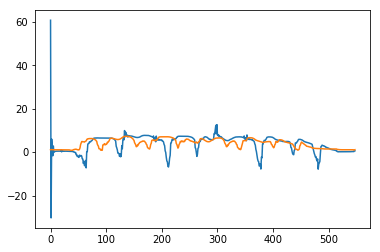

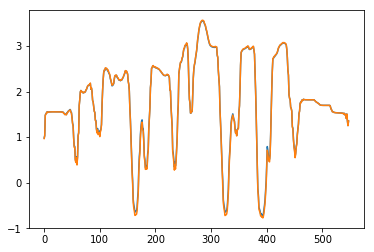

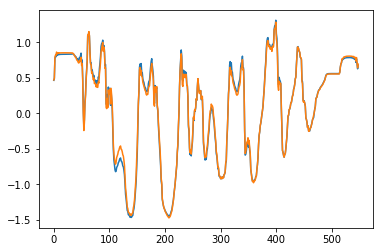

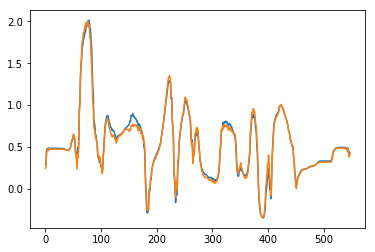

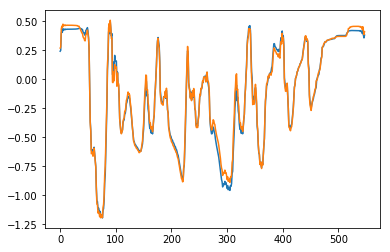

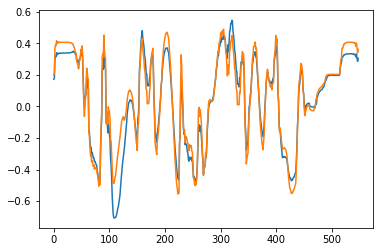

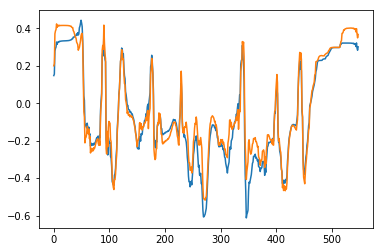

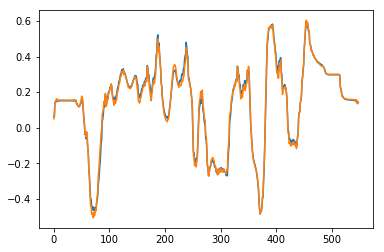

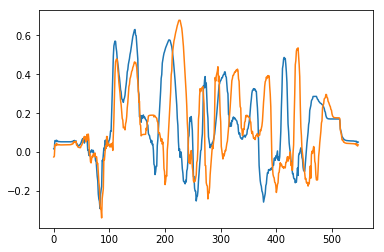

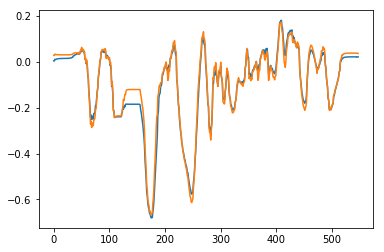

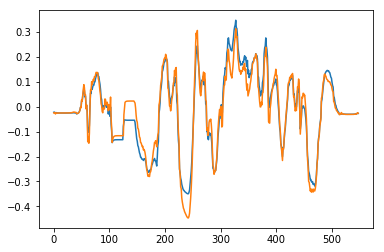

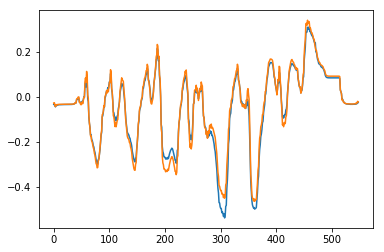

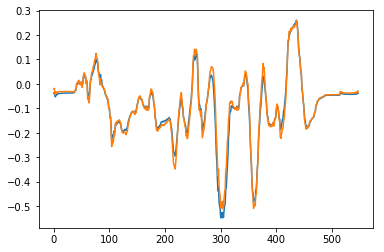

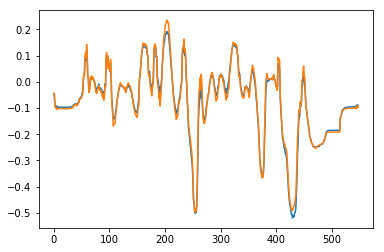

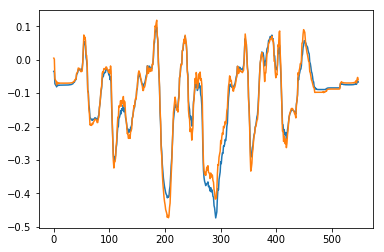

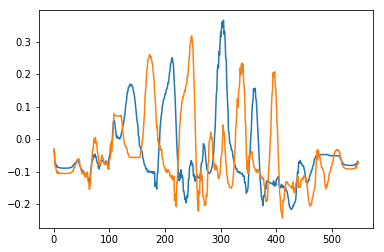

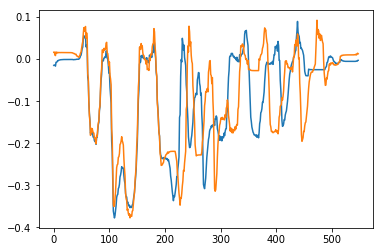

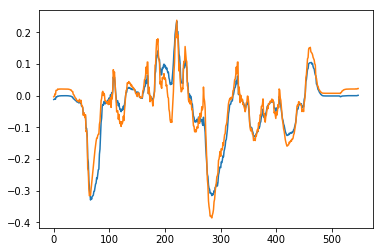

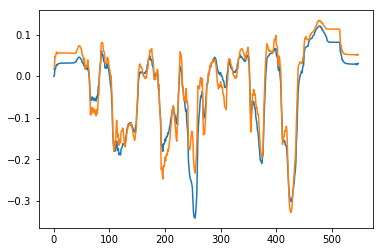

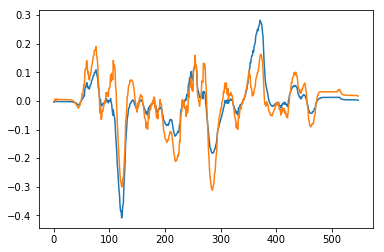

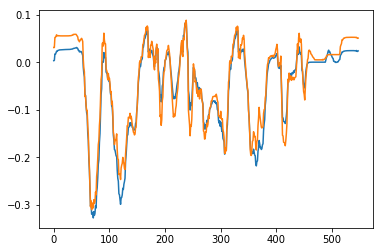

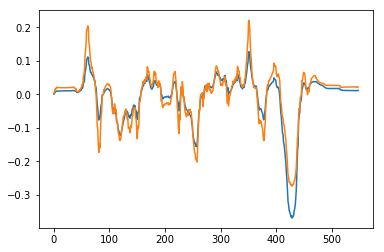

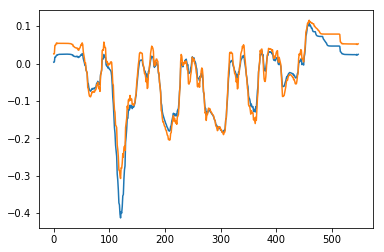

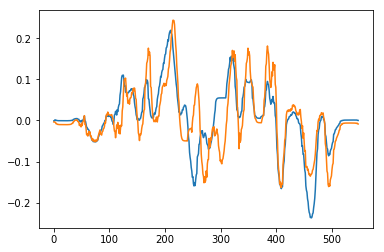

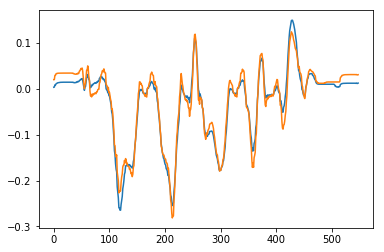

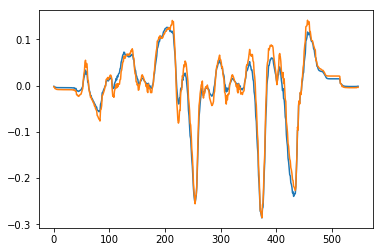

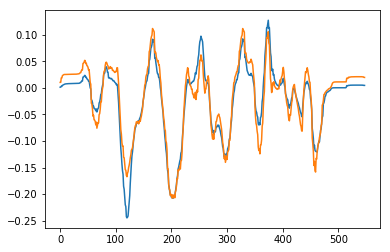

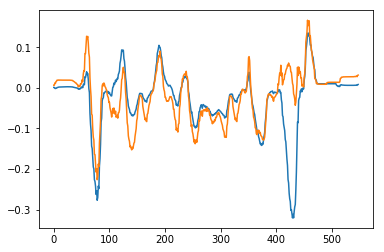

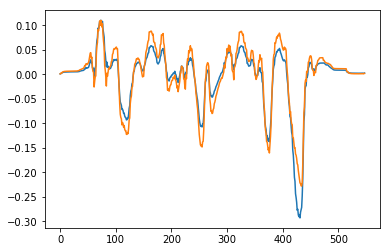

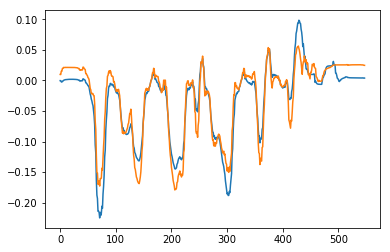

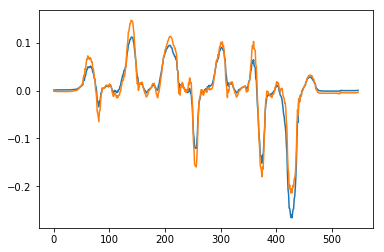

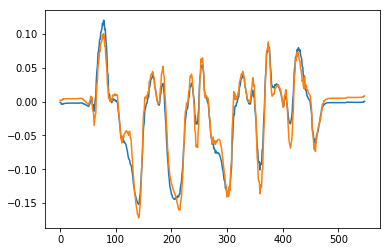

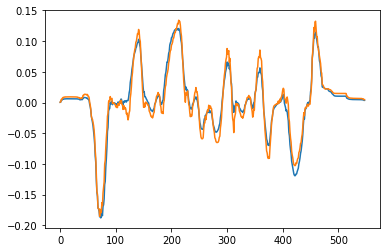

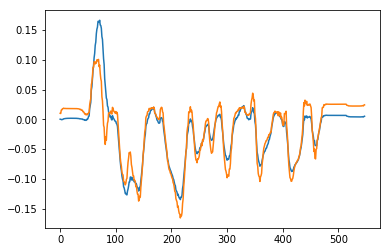

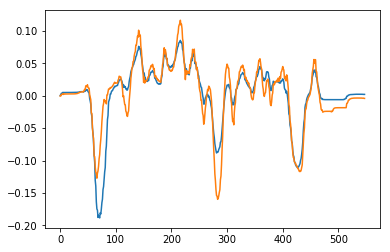

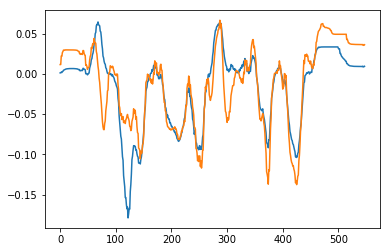

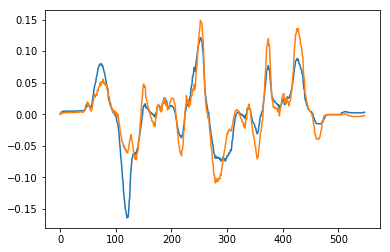

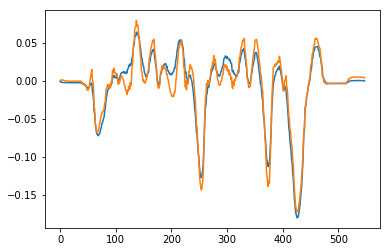

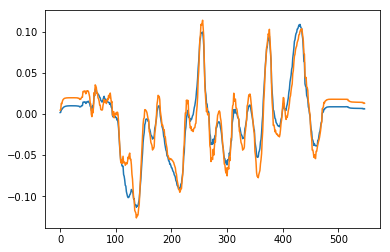

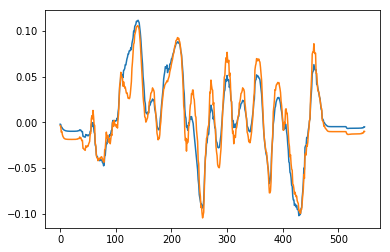

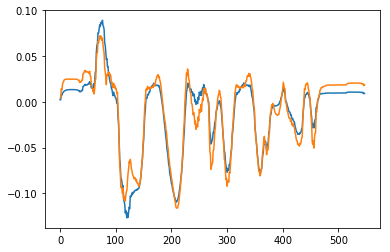

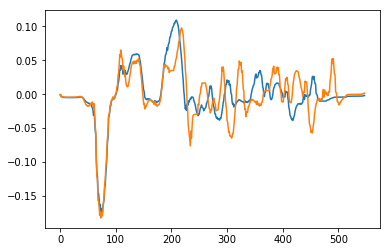

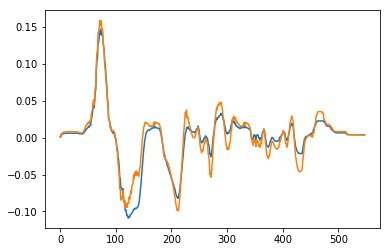

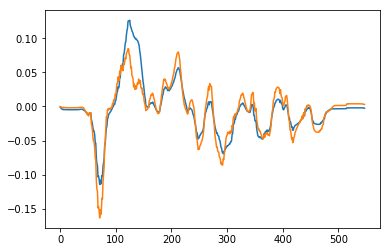

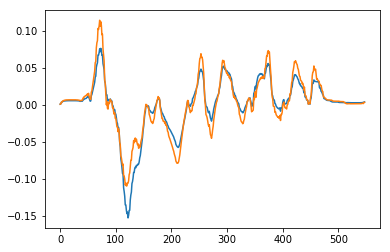

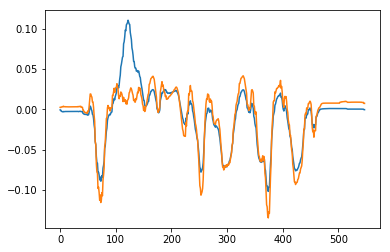

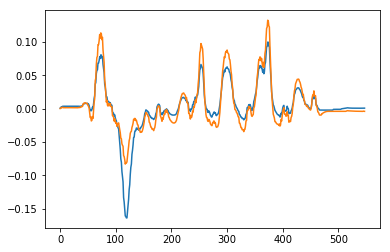

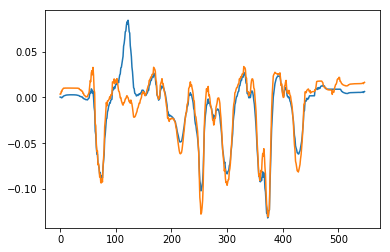

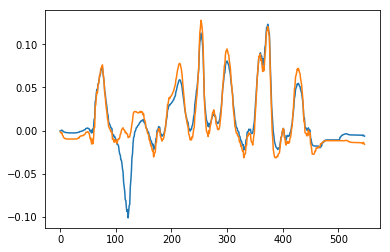

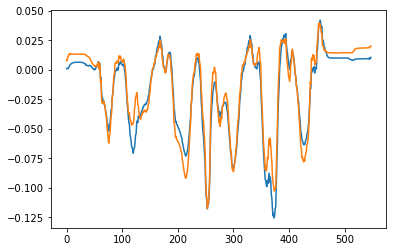

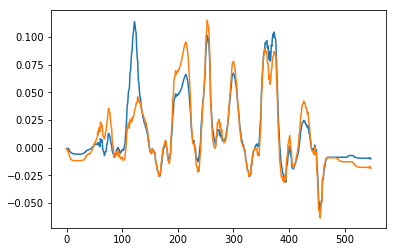

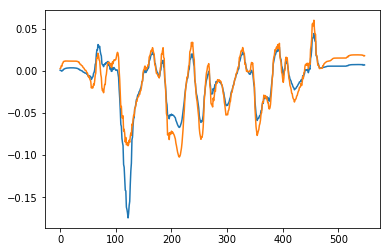

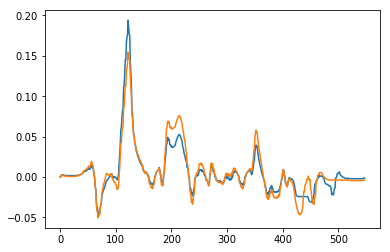

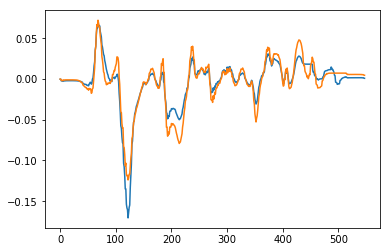

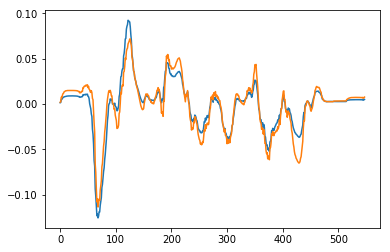

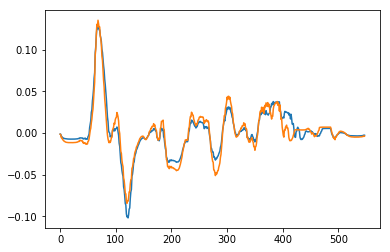

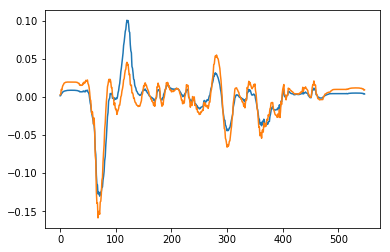

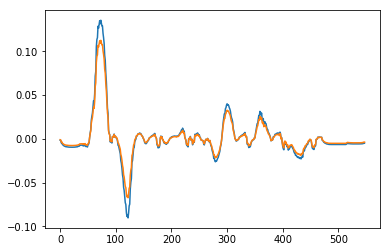

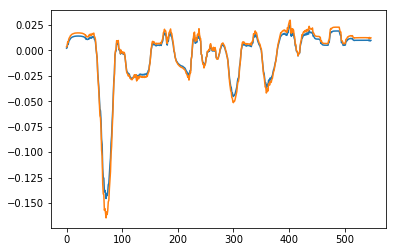

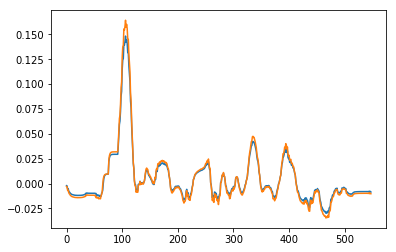

In [484]:
f='utt1'
root_folder='mass_exp'
x=load_traj('{root_f}/{file_n}/wav/mcep_generation/gv_constraint/{file_n}.mcep'.format(root_f=root_folder, file_n=f),60)
y=load_traj('{root_f}/{file_n}/wav/mcep_generation/gv_expert/{file_n}.mcep'.format(root_f=root_folder, file_n=f),60)
for m in range(0,60):
    plt.figure()
    plt.plot(x[:,m])
    plt.plot(y[:,m])

### Final Graphs

In [916]:
new_o, new_l = dtw_alignment(res3[f][m]['synth'], res3[f][m]['original'],False)
float(RMSE(new_o, new_l))

0.01755228623504202

In [919]:
a={}
a[1][2][3]=5

KeyError: 1

In [ ]:

plt.plot(range(1,61),plt_list, label=label_dict[traj])
    plt.legend()

In [ ]:
label_dict={}
label_dict['original']='Original'
label_dict['baseline']='Repeated Experts'
label_dict['synth']='Synthesized'
label_dict['poe']='Experts'
label_dict['gv_expert']='GV Experts'
label_dict['gv_constraint']='GV Constraint'


In [967]:
files = ["utt{}".format(x) for x in range(1,10)]

In [956]:
res3['utt2'][1].keys()

['baseline', 'gv_constraint', 'gv_expert', 'synth', 'poe', 'original']

In [961]:
## Global Variance Plots
gv_plt = {}
for f in files:
    f_dict={}
    for traj in ['synth','poe','gv_expert','gv_constraint', 'original']:
        plt_list = []
        for m in range(1,61):
            plt_list.append(np.var(res3[f][m][traj]))
        f_dict[traj]=plt_list
    gv_plt[f]=f_dict

In [964]:
## Alignment with Synth
synth_align = {}
for f in files:
    f_dict={}
    for traj in ['original','poe','gv_expert','gv_constraint']:
        print f, traj
        plt_list = []
        for m in range(1,61):
            new_o, new_l = dtw_alignment(res3[f][m][traj], res3[f][m]['synth'],False)
            plt_list.append(float(RMSE(new_o, new_l)))
        f_dict[traj]=plt_list
    synth_align[f]=f_dict

utt1 original
utt1 poe
utt1 gv_expert
utt1 gv_constraint
utt2 original
utt2 poe
utt2 gv_expert
utt2 gv_constraint
utt3 original
utt3 poe
utt3 gv_expert
utt3 gv_constraint
utt4 original
utt4 poe
utt4 gv_expert
utt4 gv_constraint
utt5 original
utt5 poe
utt5 gv_expert
utt5 gv_constraint
utt6 original
utt6 poe
utt6 gv_expert
utt6 gv_constraint
utt7 original
utt7 poe
utt7 gv_expert
utt7 gv_constraint
utt8 original
utt8 poe
utt8 gv_expert
utt8 gv_constraint
utt9 original
utt9 poe
utt9 gv_expert
utt9 gv_constraint


In [968]:
## Alignment with Original
org_align = {}
for f in files:
    f_dict={}
    for traj in ['synth','poe','gv_expert','gv_constraint']:
        print f, traj
        plt_list = []
        for m in range(1,61):
            new_o, new_l = dtw_alignment(res3[f][m][traj], res3[f][m]['original'],False)
            plt_list.append(float(RMSE(new_o, new_l)))
        f_dict[traj]=plt_list
    org_align[f]=f_dict

utt1 synth
utt1 poe
utt1 gv_expert
utt1 gv_constraint
utt2 synth
utt2 poe
utt2 gv_expert
utt2 gv_constraint
utt3 synth
utt3 poe
utt3 gv_expert
utt3 gv_constraint
utt4 synth
utt4 poe
utt4 gv_expert
utt4 gv_constraint
utt5 synth
utt5 poe
utt5 gv_expert
utt5 gv_constraint
utt6 synth
utt6 poe
utt6 gv_expert
utt6 gv_constraint
utt7 synth
utt7 poe
utt7 gv_expert
utt7 gv_constraint
utt8 synth
utt8 poe
utt8 gv_expert
utt8 gv_constraint
utt9 synth
utt9 poe
utt9 gv_expert
utt9 gv_constraint


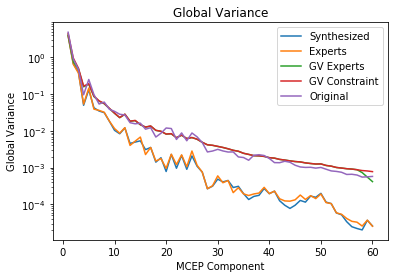

In [1006]:
f='utt8'
for traj in ['synth','poe','gv_expert','gv_constraint', 'original']:
    if traj in gv_plt[f]:
        plt.plot(range(1,61),gv_plt[f][traj], label=label_dict[traj])
plt.gca().set_yscale('log')
plt.title('Global Variance')
plt.xlabel('MCEP Component')
plt.ylabel('Global Variance')
plt.legend()
plt.savefig('figures/3_{}_gv.eps'.format(f), format='eps', dpi=1000, bbox_inches='tight')  

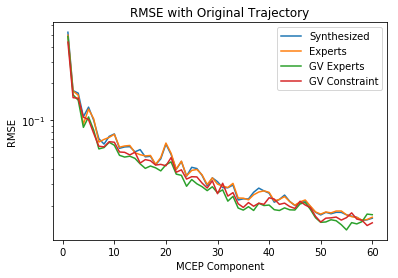

In [1007]:
for traj in ['synth','poe','gv_expert','gv_constraint', 'original']:
    if traj in org_align[f]:
        plt.plot(range(1,61),org_align[f][traj], label=label_dict[traj])
plt.gca().set_yscale('log')
#plt.ylim([0,0.05])
plt.title('RMSE with Original Trajectory')
plt.xlabel('MCEP Component')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('figures/3_{}_org_align.eps'.format(f), format='eps', dpi=1000, bbox_inches='tight')  

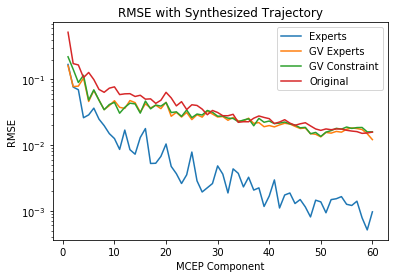

In [1008]:
for traj in ['synth','poe','gv_expert','gv_constraint', 'original']:
    if traj in synth_align[f]:
        plt.plot(range(1,61), synth_align[f][traj], label=label_dict[traj])
plt.gca().set_yscale('log')
plt.title('RMSE with Synthesized Trajectory')
plt.xlabel('MCEP Component')
plt.ylabel('RMSE')
#plt.ylim([0,0.2])
plt.legend()
plt.savefig('figures/3_{}_synth.eps'.format(f), format='eps', dpi=1000, bbox_inches='tight')  

### Traj Comparison Plot

In [47]:
res3['utt1'][1]['synth'].shape

(551,)

In [45]:
for u in res3:
    for m in res3[u]:
        res3[u][m]['synth']=load_traj('./mass_exp/{fn}/traj/{fn}.mcep'.format(fn=u), 60)[:,m-1]
    

In [1012]:
res3['utt2'][7].keys()

['baseline', 'gv_constraint', 'gv_expert', 'synth', 'poe', 'original']

1 & 4 & Experts & 0.118 & 0.019 \\\hline
1 & 4 & GV Experts & 0.105 & 0.069 \\\hline
1 & 4 & GV Constraint & 0.111 & 0.070 \\\hline
3 & 30 & Experts & 0.028 & 0.001 \\\hline
3 & 30 & GV Experts & 0.023 & 0.020 \\\hline
3 & 30 & GV Constraint & 0.024 & 0.022 \\\hline
9 & 55 & Experts & 0.018 & 0.002 \\\hline
9 & 55 & GV Experts & 0.016 & 0.014 \\\hline
9 & 55 & GV Constraint & 0.016 & 0.019 \\\hline


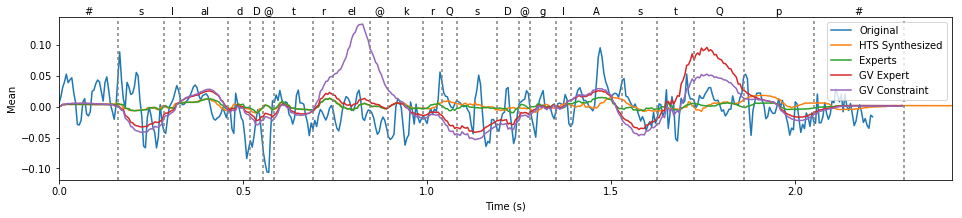

In [1028]:
def plot_traj(filename, dim):
    int_dur_exp = read_durations('./mass_exp/{filename}/expts/{dim}/{filename}.dur.expt'.format(filename=filename, dim=dim))
    labels_list = read_durations('./mass_exp/{filename}/expts/{dim}/{filename}.dur.expt'.format(filename=filename, dim=dim), True)
    lab_ends = np.cumsum(np.sum(int_dur_exp.reshape(-1,5),axis=1))*0.005
    lab_ends_full = np.cumsum(int_dur_exp)*0.005
    lab_starts = np.concatenate(([0],lab_ends[0:-1]))
    lab_ticks = (lab_ends + lab_starts)/2

    plot_x = [0.005*x for x in range(0,len(res3[filename][dim]['poe']))]
    plot_x_synth = [0.005*x for x in range(0,len(res3[filename][dim]['synth']))]
    plot_x_org = [0.005*x for x in range(0,len(res3[filename][dim]['original']))]

    plt.clf()
    plt.figure(figsize=(16,3))
    plt.plot(plot_x_org, res3[filename][dim]['original'], label="Original")
    plt.plot(plot_x_synth, res3[filename][dim]['synth'], label="HTS Synthesized")
    plt.plot(plot_x,res3[filename][dim]['poe'], label="Experts")
    plt.plot(plot_x, res3[filename][dim]['gv_expert'], label="GV Expert")
    plt.plot(plot_x, res3[filename][dim]['gv_constraint'], label="GV Constraint")
    plt.xlim([0,max(plot_x+plot_x_org+plot_x_synth)])


    for i in range(0,len(labels_list)):
        plt.axvline(x=lab_ends[i], color='gray',  dashes=[2, 2])
        plt.text(lab_ticks[i], plt.gca().get_ylim()[1], labels_list[i], rotation=0, horizontalalignment='center', verticalalignment='bottom')
        
    for traj in ['poe','gv_expert','gv_constraint']:
        new_o, new_l = dtw_alignment(res3[filename][dim][traj], res3[filename][dim]['original'],False)
        odist = RMSE(new_o,new_l)
        new_o, new_l = dtw_alignment(res3[filename][dim][traj], res3[filename][dim]['synth'],False)
        sdist = RMSE(new_o,new_l)
        print "{} & {} & {} & {:1.3f} & {:1.3f} \\\\\\hline".format(filename[3], dim, label_dict[traj], odist, sdist )

    #2.2 Trajectories
    plt.xlabel("Time (s)")
    plt.ylabel("Mean")
    plt.legend(loc=1)
    #plt.savefig('figures/3_{}_{}_traj.eps'.format(filename, dim), format='eps', dpi=1000, bbox_inches='tight')
    #plt.grid()
    #plt.show()
plot_traj('utt1', 4)
plot_traj('utt3', 30)
plot_traj('utt9', 55)

### Heatmap

In [1058]:
import seaborn as sns
import pandas as pd


[(0.85840830449826988, 0.91344867358708182, 0.9645674740484429),
 (0.73094963475586316, 0.83947712418300646, 0.92132256824298342),
 (0.53568627450980388, 0.74608227604767396, 0.8642522106881968),
 (0.32628988850442137, 0.61862360630526725, 0.80279892349096504),
 (0.16696655132641292, 0.48069204152249134, 0.72915032679738567),
 (0.044059976931949255, 0.33388696655132638, 0.62445213379469444)]

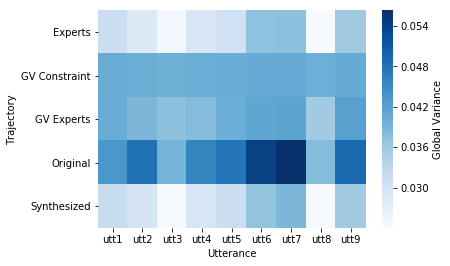

In [1063]:
sns.heatmap(pd.DataFrame.from_dict(gv_plt_mean), cbar_kws={'label': 'Global Variance'}, cmap="Blues")
plt.xlabel('Utterance')
plt.ylabel('Trajectory')
plt.savefig('figures/3_hm_gv.eps', format='eps', dpi=1000, bbox_inches='tight')

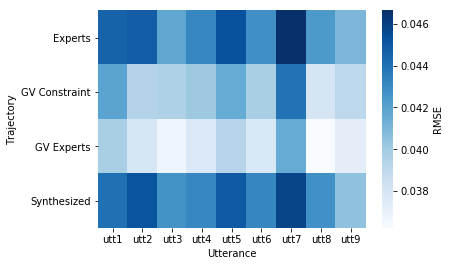

In [1064]:
sns.heatmap(pd.DataFrame.from_dict(org_align_mean), cbar_kws={'label': 'RMSE'}, cmap="Blues")
plt.xlabel('Utterance')
plt.ylabel('Trajectory')
plt.savefig('figures/3_hm_rmse.eps', format='eps', dpi=1000, bbox_inches='tight')

In [1048]:
gv_plt_mean = {}
for k1 in gv_plt:
    f2={}
    for k2 in gv_plt[k1]:
        f2[label_dict[k2]]=np.mean(gv_plt[k1][k2][1:])
    gv_plt_mean[k1]=f2

In [1049]:
org_align_mean = {}
for k1 in org_align:
    f2={}
    for k2 in org_align[k1]:
        f2[label_dict[k2]]=np.mean(org_align[k1][k2][1:])
    org_align_mean[k1]=f2